In [17]:
import keras
from keras.models import Sequential
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
import pickle
import datetime

In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [05:01<00:00, 140.66it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(42378, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [01:26<00:00, 101.62it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(8803, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(y_train.shape)
print(y_test.shape)
train.nunique()
val.nunique()

(42378,)
(8803,)


image    8803
class      51
dtype: int64

In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
# creating the base model of pre-trained VGG16 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 1536)


In [12]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
________________________________________________________________________________

__________________________________________________________________________________________________
mixed_5b (Concatenate)          (None, None, None, 3 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 3 10240       mixed_5b[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 3 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 3 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, None, 3 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_24 (Activation)      (None, None, None, 6 0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, None, None, 1 0           activation_19[0][0]              
                                                                 activation_21[0][0]              
                                                                 activation_24[0][0]              
__________

__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 3 10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, None, 3 9216        activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, None, None, 6 27648       activation_35[0][0]              
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, None, None, 3 96          conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, None, 3 96          conv2d_33[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 3 10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, None, None, 4 13824       activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 3 96          conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, None, None, 4 144         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, None, None, 3 0           batch_normalization_44[0][0]     
__________

block35_7_conv (Conv2D)         (None, None, None, 3 41280       block35_7_mixed[0][0]            
__________________________________________________________________________________________________
block35_7 (Lambda)              (None, None, None, 3 0           block35_6_ac[0][0]               
                                                                 block35_7_conv[0][0]             
__________________________________________________________________________________________________
block35_7_ac (Activation)       (None, None, None, 3 0           block35_7[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 3 10240       block35_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, None, None, 3 96          conv2d_58[0][0]                  
__________

batch_normalization_66 (BatchNo (None, None, None, 6 192         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, None, None, 3 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, None, None, 3 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_66 (Activation)      (None, None, None, 6 0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, None, None, 1 0           activation_61[0][0]              
                                                                 activation_63[0][0]              
          

batch_normalization_73 (BatchNo (None, None, None, 3 1152        conv2d_73[0][0]                  
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, None, None, 3 1152        conv2d_76[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, None, None, 3 0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
activation_76 (Activation)      (None, None, None, 3 0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 3 0           block35_10_ac[0][0]              
__________________________________________________________________________________________________
mixed_6a (

conv2d_86 (Conv2D)              (None, None, None, 1 139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, None, None, 1 384         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, None, None, 1 0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, None, None, 1 143360      activation_86[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, None, None, 1 480         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation

conv2d_96 (Conv2D)              (None, None, None, 1 215040      activation_95[0][0]              
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, None, None, 1 576         conv2d_93[0][0]                  
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, None, None, 1 576         conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 1 0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
activation_96 (Activation)      (None, None, None, 1 0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
block17_5_

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, None, None, 1 0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, None, None, 1 0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, None, None, 1 139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, None, None, 1 384         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation

batch_normalization_115 (BatchN (None, None, None, 1 480         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, None, None, 1 0           batch_normalization_115[0][0]    
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, None, None, 1 208896      block17_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, None, None, 1 215040      activation_115[0][0]             
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, None, None, 1 576         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_124 (Activation)     (None, None, None, 1 0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, None, None, 3 0           activation_121[0][0]             
                                                                 activation_124[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, None, None, 1 418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, None, None, 1 0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_134 (BatchN (None, None, None, 1 384         conv2d_134[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, None, None, 1 0           batch_normalization_134[0][0]    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, None, None, 1 143360      activation_134[0][0]             
__________________________________________________________________________________________________
batch_normalization_135 (BatchN (None, None, None, 1 480         conv2d_135[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, None, None, 1 0           batch_normalization_135[0][0]    
__________________________________________________________________________________________________
conv2d_133

batch_normalization_141 (BatchN (None, None, None, 1 576         conv2d_141[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, None, None, 1 576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_141 (Activation)     (None, None, None, 1 0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, None, None, 1 0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, None, None, 3 0           activation_141[0][0]             
                                                                 activation_144[0][0]             
__________

                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, None, None, 1 0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, None, None, 1 139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 384         conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_154 (Activation)     (None, None, None, 1 0           batch_normalization_154[0][0]    
__________________________________________________________________________________________________
conv2d_155

mixed_7a (Concatenate)          (None, None, None, 2 0           activation_158[0][0]             
                                                                 activation_160[0][0]             
                                                                 activation_163[0][0]             
                                                                 max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, None, None, 1 399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, None, None, 1 576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, None, None, 1 0           batch_normalization_165[0][0]    
__________

__________________________________________________________________________________________________
activation_174 (Activation)     (None, None, None, 2 0           batch_normalization_174[0][0]    
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, None, None, 1 399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, None, None, 2 172032      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, None, None, 1 576         conv2d_172[0][0]                 
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, None, None, 2 768         conv2d_175[0][0]                 
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, None, None, 4 0           activation_180[0][0]             
                                                                 activation_183[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, None, None, 2 933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, None, None, 2 0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, None, None, 2 0           block8_5[0][0]                   
__________

__________________________________________________________________________________________________
activation_193 (Activation)     (None, None, None, 1 0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, None, None, 2 129024      activation_193[0][0]             
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, None, None, 2 672         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_194 (Activation)     (None, None, None, 2 0           batch_normalization_194[0][0]    
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, None, None, 1 399360      block8_7_ac[0][0]                
__________

__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, None, None, 2 768         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, None, None, 1 0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
activation_203 (Activation)     (None, None, None, 2 0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, None, None, 4 0           activation_200[0][0]             
                                                                 activation_203[0][0]             
__________________________________________________________________________________________________
block8_10_

In [13]:
base_model.get_config()

{'name': 'inception_resnet_v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[[

In [18]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

2020-09-02 01:41:43.841025
(42378, 5, 5, 1536)
6:33:12.384639


In [19]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(42378, 5*5*1536)

In [20]:
pickle_out = open('../Pickle/InceptionResNetV2_X_train_OF.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [21]:
pickle_in = open('../Pickle/InceptionResNetV2_X_train_OF.pickle',"rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)

(42378, 38400)


In [22]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(8803, 5, 5, 1536)

In [23]:
X_test = X_test.reshape(8803, 5*5*1536)

In [24]:
# Save the model as a pickle in a file 
joblib.dump(X_test, '../Pickle/InceptionResNetV2_X_test.pkl')

['../Pickle/InceptionResNetV2_X_test.pkl']

In [25]:
# Load the model from the file 
X_test = joblib.load('../Pickle/InceptionResNetV2_X_test.pkl') 

In [26]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 38400)
(8803, 38400)
(42378, 51)
(8803, 51)


In [27]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(38400,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [28]:
model.output_shape

(None, 51)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              39322624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [30]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 38400),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [31]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightInceptionResNetV2_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [32]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [33]:
# training the model
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Train on 42378 samples, validate on 8803 samples
Epoch 1/100


23552/42378 [===============>..............] - ETA: 11:16 - loss: 5.5890 - accuracy: 0.039 - ETA: 6:52 - loss: 13.4196 - accuracy: 0.035 - ETA: 5:23 - loss: 14.5697 - accuracy: 0.028 - ETA: 4:37 - loss: 14.5639 - accuracy: 0.031 - ETA: 4:09 - loss: 14.2969 - accuracy: 0.028 - ETA: 3:51 - loss: 13.9451 - accuracy: 0.024 - ETA: 3:37 - loss: 13.5136 - accuracy: 0.023 - ETA: 3:27 - loss: 13.0587 - accuracy: 0.023 - ETA: 3:20 - loss: 12.5830 - accuracy: 0.021 - ETA: 3:14 - loss: 12.0829 - accuracy: 0.019 - ETA: 3:08 - loss: 11.6361 - accuracy: 0.020 - ETA: 3:03 - loss: 11.2228 - accuracy: 0.020 - ETA: 3:00 - loss: 10.8696 - accuracy: 0.020 - ETA: 2:56 - loss: 10.5383 - accuracy: 0.020 - ETA: 2:53 - loss: 10.1827 - accuracy: 0.019 - ETA: 2:50 - loss: 9.8701 - accuracy: 0.020 - ETA: 2:48 - loss: 9.5672 - accuracy: 0.02 - ETA: 2:46 - loss: 9.2981 - accuracy: 0.02 - ETA: 2:44 - loss: 9.0545 - accuracy: 0.02 - ETA: 2:42 - loss: 8.8212 - accuracy: 0.02 - ETA: 2:40 - loss: 8.6105 - accuracy: 0.02 

42378/42378 [==============================] - ETA: 1:08 - loss: 4.4720 - accuracy: 0.03 - ETA: 1:07 - loss: 4.4689 - accuracy: 0.03 - ETA: 1:07 - loss: 4.4662 - accuracy: 0.03 - ETA: 1:06 - loss: 4.4633 - accuracy: 0.03 - ETA: 1:06 - loss: 4.4605 - accuracy: 0.03 - ETA: 1:05 - loss: 4.4579 - accuracy: 0.03 - ETA: 1:05 - loss: 4.4550 - accuracy: 0.03 - ETA: 1:04 - loss: 4.4516 - accuracy: 0.03 - ETA: 1:04 - loss: 4.4487 - accuracy: 0.03 - ETA: 1:03 - loss: 4.4457 - accuracy: 0.03 - ETA: 1:03 - loss: 4.4428 - accuracy: 0.03 - ETA: 1:02 - loss: 4.4400 - accuracy: 0.03 - ETA: 1:02 - loss: 4.4371 - accuracy: 0.03 - ETA: 1:01 - loss: 4.4343 - accuracy: 0.03 - ETA: 1:01 - loss: 4.4315 - accuracy: 0.03 - ETA: 1:00 - loss: 4.4286 - accuracy: 0.03 - ETA: 1:00 - loss: 4.4257 - accuracy: 0.03 - ETA: 59s - loss: 4.4228 - accuracy: 0.0361 - ETA: 59s - loss: 4.4202 - accuracy: 0.036 - ETA: 59s - loss: 4.4176 - accuracy: 0.036 - ETA: 58s - loss: 4.4147 - accuracy: 0.036 - ETA: 58s - loss: 4.4120 - ac

23808/42378 [===============>..............] - ETA: 2:33 - loss: 3.7913 - accuracy: 0.06 - ETA: 2:31 - loss: 3.7979 - accuracy: 0.05 - ETA: 2:28 - loss: 3.7619 - accuracy: 0.07 - ETA: 2:26 - loss: 3.7935 - accuracy: 0.06 - ETA: 2:25 - loss: 3.7743 - accuracy: 0.07 - ETA: 2:24 - loss: 3.7770 - accuracy: 0.06 - ETA: 2:23 - loss: 3.7859 - accuracy: 0.06 - ETA: 2:22 - loss: 3.7928 - accuracy: 0.06 - ETA: 2:21 - loss: 3.7806 - accuracy: 0.07 - ETA: 2:20 - loss: 3.7843 - accuracy: 0.06 - ETA: 2:20 - loss: 3.7905 - accuracy: 0.07 - ETA: 2:20 - loss: 3.7908 - accuracy: 0.07 - ETA: 2:19 - loss: 3.7936 - accuracy: 0.06 - ETA: 2:19 - loss: 3.7991 - accuracy: 0.06 - ETA: 2:18 - loss: 3.7987 - accuracy: 0.06 - ETA: 2:18 - loss: 3.8023 - accuracy: 0.06 - ETA: 2:18 - loss: 3.8068 - accuracy: 0.06 - ETA: 2:17 - loss: 3.8113 - accuracy: 0.06 - ETA: 2:17 - loss: 3.8115 - accuracy: 0.06 - ETA: 2:17 - loss: 3.8139 - accuracy: 0.06 - ETA: 2:17 - loss: 3.8097 - accuracy: 0.06 - ETA: 2:16 - loss: 3.8094 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.7859 - accuracy: 0.06 - ETA: 1:05 - loss: 3.7863 - accuracy: 0.06 - ETA: 1:04 - loss: 3.7865 - accuracy: 0.06 - ETA: 1:04 - loss: 3.7861 - accuracy: 0.06 - ETA: 1:03 - loss: 3.7860 - accuracy: 0.06 - ETA: 1:03 - loss: 3.7861 - accuracy: 0.06 - ETA: 1:02 - loss: 3.7866 - accuracy: 0.06 - ETA: 1:02 - loss: 3.7864 - accuracy: 0.06 - ETA: 1:01 - loss: 3.7862 - accuracy: 0.06 - ETA: 1:01 - loss: 3.7857 - accuracy: 0.06 - ETA: 1:00 - loss: 3.7857 - accuracy: 0.06 - ETA: 1:00 - loss: 3.7860 - accuracy: 0.06 - ETA: 1:00 - loss: 3.7857 - accuracy: 0.06 - ETA: 59s - loss: 3.7851 - accuracy: 0.0614 - ETA: 59s - loss: 3.7849 - accuracy: 0.061 - ETA: 58s - loss: 3.7854 - accuracy: 0.061 - ETA: 58s - loss: 3.7851 - accuracy: 0.061 - ETA: 57s - loss: 3.7848 - accuracy: 0.061 - ETA: 57s - loss: 3.7844 - accuracy: 0.061 - ETA: 56s - loss: 3.7839 - accuracy: 0.061 - ETA: 56s - loss: 3.7836 - accuracy: 0.061 - ETA: 55s - loss: 3.7844 - ac

23808/42378 [===============>..............] - ETA: 2:36 - loss: 3.7777 - accuracy: 0.07 - ETA: 2:29 - loss: 3.7878 - accuracy: 0.07 - ETA: 2:27 - loss: 3.7284 - accuracy: 0.09 - ETA: 2:26 - loss: 3.7707 - accuracy: 0.08 - ETA: 2:26 - loss: 3.7501 - accuracy: 0.09 - ETA: 2:25 - loss: 3.7750 - accuracy: 0.08 - ETA: 2:24 - loss: 3.7672 - accuracy: 0.08 - ETA: 2:23 - loss: 3.7623 - accuracy: 0.08 - ETA: 2:23 - loss: 3.7582 - accuracy: 0.08 - ETA: 2:23 - loss: 3.7487 - accuracy: 0.08 - ETA: 2:23 - loss: 3.7403 - accuracy: 0.08 - ETA: 2:22 - loss: 3.7494 - accuracy: 0.08 - ETA: 2:22 - loss: 3.7404 - accuracy: 0.08 - ETA: 2:21 - loss: 3.7422 - accuracy: 0.08 - ETA: 2:21 - loss: 3.7397 - accuracy: 0.07 - ETA: 2:20 - loss: 3.7424 - accuracy: 0.08 - ETA: 2:20 - loss: 3.7362 - accuracy: 0.08 - ETA: 2:20 - loss: 3.7315 - accuracy: 0.08 - ETA: 2:19 - loss: 3.7295 - accuracy: 0.08 - ETA: 2:18 - loss: 3.7391 - accuracy: 0.08 - ETA: 2:19 - loss: 3.7405 - accuracy: 0.08 - ETA: 2:19 - loss: 3.7429 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.7362 - accuracy: 0.07 - ETA: 1:04 - loss: 3.7366 - accuracy: 0.07 - ETA: 1:04 - loss: 3.7363 - accuracy: 0.07 - ETA: 1:04 - loss: 3.7358 - accuracy: 0.07 - ETA: 1:03 - loss: 3.7359 - accuracy: 0.07 - ETA: 1:03 - loss: 3.7357 - accuracy: 0.07 - ETA: 1:02 - loss: 3.7355 - accuracy: 0.07 - ETA: 1:02 - loss: 3.7354 - accuracy: 0.07 - ETA: 1:01 - loss: 3.7354 - accuracy: 0.07 - ETA: 1:01 - loss: 3.7349 - accuracy: 0.07 - ETA: 1:00 - loss: 3.7350 - accuracy: 0.07 - ETA: 1:00 - loss: 3.7349 - accuracy: 0.07 - ETA: 1:00 - loss: 3.7343 - accuracy: 0.07 - ETA: 59s - loss: 3.7354 - accuracy: 0.0795 - ETA: 59s - loss: 3.7352 - accuracy: 0.079 - ETA: 58s - loss: 3.7350 - accuracy: 0.079 - ETA: 58s - loss: 3.7346 - accuracy: 0.079 - ETA: 57s - loss: 3.7341 - accuracy: 0.079 - ETA: 57s - loss: 3.7341 - accuracy: 0.079 - ETA: 56s - loss: 3.7341 - accuracy: 0.079 - ETA: 56s - loss: 3.7335 - accuracy: 0.080 - ETA: 55s - loss: 3.7334 - ac

23808/42378 [===============>..............] - ETA: 2:57 - loss: 3.6779 - accuracy: 0.07 - ETA: 2:38 - loss: 3.5479 - accuracy: 0.10 - ETA: 2:31 - loss: 3.6067 - accuracy: 0.10 - ETA: 2:28 - loss: 3.6465 - accuracy: 0.09 - ETA: 2:27 - loss: 3.6783 - accuracy: 0.09 - ETA: 2:25 - loss: 3.6841 - accuracy: 0.09 - ETA: 2:25 - loss: 3.6935 - accuracy: 0.09 - ETA: 2:25 - loss: 3.6980 - accuracy: 0.08 - ETA: 2:25 - loss: 3.6871 - accuracy: 0.09 - ETA: 2:24 - loss: 3.6920 - accuracy: 0.09 - ETA: 2:24 - loss: 3.6967 - accuracy: 0.09 - ETA: 2:23 - loss: 3.7010 - accuracy: 0.09 - ETA: 2:23 - loss: 3.6941 - accuracy: 0.09 - ETA: 2:23 - loss: 3.6802 - accuracy: 0.09 - ETA: 2:22 - loss: 3.6829 - accuracy: 0.09 - ETA: 2:22 - loss: 3.6834 - accuracy: 0.09 - ETA: 2:22 - loss: 3.6755 - accuracy: 0.09 - ETA: 2:21 - loss: 3.6737 - accuracy: 0.09 - ETA: 2:20 - loss: 3.6761 - accuracy: 0.09 - ETA: 2:20 - loss: 3.6847 - accuracy: 0.09 - ETA: 2:19 - loss: 3.6877 - accuracy: 0.09 - ETA: 2:19 - loss: 3.6866 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.6872 - accuracy: 0.08 - ETA: 1:04 - loss: 3.6874 - accuracy: 0.08 - ETA: 1:04 - loss: 3.6877 - accuracy: 0.08 - ETA: 1:03 - loss: 3.6871 - accuracy: 0.08 - ETA: 1:03 - loss: 3.6869 - accuracy: 0.08 - ETA: 1:02 - loss: 3.6862 - accuracy: 0.08 - ETA: 1:02 - loss: 3.6865 - accuracy: 0.08 - ETA: 1:02 - loss: 3.6868 - accuracy: 0.08 - ETA: 1:01 - loss: 3.6866 - accuracy: 0.08 - ETA: 1:01 - loss: 3.6860 - accuracy: 0.08 - ETA: 1:00 - loss: 3.6861 - accuracy: 0.08 - ETA: 1:00 - loss: 3.6859 - accuracy: 0.08 - ETA: 59s - loss: 3.6856 - accuracy: 0.0885 - ETA: 59s - loss: 3.6857 - accuracy: 0.088 - ETA: 58s - loss: 3.6859 - accuracy: 0.088 - ETA: 58s - loss: 3.6867 - accuracy: 0.088 - ETA: 58s - loss: 3.6856 - accuracy: 0.088 - ETA: 57s - loss: 3.6858 - accuracy: 0.088 - ETA: 57s - loss: 3.6853 - accuracy: 0.088 - ETA: 56s - loss: 3.6851 - accuracy: 0.088 - ETA: 56s - loss: 3.6855 - accuracy: 0.088 - ETA: 55s - loss: 3.6858 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 3.6752 - accuracy: 0.08 - ETA: 2:36 - loss: 3.6745 - accuracy: 0.08 - ETA: 2:34 - loss: 3.7171 - accuracy: 0.06 - ETA: 2:30 - loss: 3.7101 - accuracy: 0.07 - ETA: 2:27 - loss: 3.7086 - accuracy: 0.06 - ETA: 2:26 - loss: 3.6894 - accuracy: 0.07 - ETA: 2:25 - loss: 3.6944 - accuracy: 0.07 - ETA: 2:25 - loss: 3.6816 - accuracy: 0.08 - ETA: 2:25 - loss: 3.6802 - accuracy: 0.08 - ETA: 2:24 - loss: 3.6630 - accuracy: 0.08 - ETA: 2:24 - loss: 3.6701 - accuracy: 0.08 - ETA: 2:23 - loss: 3.6869 - accuracy: 0.08 - ETA: 2:22 - loss: 3.6822 - accuracy: 0.08 - ETA: 2:22 - loss: 3.6743 - accuracy: 0.08 - ETA: 2:21 - loss: 3.6753 - accuracy: 0.08 - ETA: 2:21 - loss: 3.6759 - accuracy: 0.08 - ETA: 2:20 - loss: 3.6758 - accuracy: 0.08 - ETA: 2:20 - loss: 3.6672 - accuracy: 0.08 - ETA: 2:20 - loss: 3.6664 - accuracy: 0.08 - ETA: 2:19 - loss: 3.6595 - accuracy: 0.08 - ETA: 2:19 - loss: 3.6548 - accuracy: 0.09 - ETA: 2:20 - loss: 3.6481 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.6500 - accuracy: 0.09 - ETA: 1:04 - loss: 3.6503 - accuracy: 0.09 - ETA: 1:04 - loss: 3.6501 - accuracy: 0.09 - ETA: 1:03 - loss: 3.6497 - accuracy: 0.09 - ETA: 1:03 - loss: 3.6494 - accuracy: 0.09 - ETA: 1:02 - loss: 3.6492 - accuracy: 0.09 - ETA: 1:02 - loss: 3.6492 - accuracy: 0.09 - ETA: 1:01 - loss: 3.6497 - accuracy: 0.09 - ETA: 1:01 - loss: 3.6495 - accuracy: 0.09 - ETA: 1:01 - loss: 3.6496 - accuracy: 0.09 - ETA: 1:00 - loss: 3.6499 - accuracy: 0.09 - ETA: 1:00 - loss: 3.6501 - accuracy: 0.09 - ETA: 59s - loss: 3.6503 - accuracy: 0.0930 - ETA: 59s - loss: 3.6498 - accuracy: 0.093 - ETA: 58s - loss: 3.6501 - accuracy: 0.093 - ETA: 58s - loss: 3.6501 - accuracy: 0.093 - ETA: 57s - loss: 3.6495 - accuracy: 0.093 - ETA: 57s - loss: 3.6491 - accuracy: 0.093 - ETA: 56s - loss: 3.6493 - accuracy: 0.093 - ETA: 56s - loss: 3.6487 - accuracy: 0.093 - ETA: 56s - loss: 3.6476 - accuracy: 0.093 - ETA: 55s - loss: 3.6472 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.5978 - accuracy: 0.09 - ETA: 3:58 - loss: 3.6865 - accuracy: 0.08 - ETA: 3:59 - loss: 3.6270 - accuracy: 0.09 - ETA: 4:01 - loss: 3.6366 - accuracy: 0.09 - ETA: 3:57 - loss: 3.6532 - accuracy: 0.09 - ETA: 3:56 - loss: 3.6373 - accuracy: 0.09 - ETA: 3:56 - loss: 3.6414 - accuracy: 0.08 - ETA: 3:56 - loss: 3.6473 - accuracy: 0.08 - ETA: 3:55 - loss: 3.6668 - accuracy: 0.08 - ETA: 3:55 - loss: 3.6712 - accuracy: 0.08 - ETA: 3:54 - loss: 3.6471 - accuracy: 0.09 - ETA: 3:53 - loss: 3.6507 - accuracy: 0.09 - ETA: 3:53 - loss: 3.6492 - accuracy: 0.09 - ETA: 3:53 - loss: 3.6530 - accuracy: 0.08 - ETA: 3:52 - loss: 3.6512 - accuracy: 0.09 - ETA: 3:51 - loss: 3.6393 - accuracy: 0.09 - ETA: 3:50 - loss: 3.6447 - accuracy: 0.09 - ETA: 3:50 - loss: 3.6433 - accuracy: 0.09 - ETA: 3:49 - loss: 3.6343 - accuracy: 0.09 - ETA: 3:48 - loss: 3.6335 - accuracy: 0.09 - ETA: 3:47 - loss: 3.6352 - accuracy: 0.09 - ETA: 3:47 - loss: 3.6408 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.6260 - accuracy: 0.09 - ETA: 1:45 - loss: 3.6262 - accuracy: 0.09 - ETA: 1:44 - loss: 3.6263 - accuracy: 0.09 - ETA: 1:43 - loss: 3.6270 - accuracy: 0.09 - ETA: 1:43 - loss: 3.6272 - accuracy: 0.09 - ETA: 1:42 - loss: 3.6269 - accuracy: 0.09 - ETA: 1:41 - loss: 3.6258 - accuracy: 0.09 - ETA: 1:40 - loss: 3.6257 - accuracy: 0.09 - ETA: 1:40 - loss: 3.6263 - accuracy: 0.09 - ETA: 1:39 - loss: 3.6257 - accuracy: 0.09 - ETA: 1:38 - loss: 3.6254 - accuracy: 0.09 - ETA: 1:37 - loss: 3.6247 - accuracy: 0.09 - ETA: 1:37 - loss: 3.6248 - accuracy: 0.09 - ETA: 1:36 - loss: 3.6248 - accuracy: 0.09 - ETA: 1:35 - loss: 3.6248 - accuracy: 0.09 - ETA: 1:34 - loss: 3.6247 - accuracy: 0.09 - ETA: 1:34 - loss: 3.6252 - accuracy: 0.09 - ETA: 1:33 - loss: 3.6247 - accuracy: 0.09 - ETA: 1:32 - loss: 3.6246 - accuracy: 0.09 - ETA: 1:32 - loss: 3.6239 - accuracy: 0.09 - ETA: 1:31 - loss: 3.6237 - accuracy: 0.09 - ETA: 1:30 - loss: 3.6236 - ac

23808/42378 [===============>..............] - ETA: 3:59 - loss: 3.5406 - accuracy: 0.11 - ETA: 4:02 - loss: 3.6062 - accuracy: 0.10 - ETA: 4:01 - loss: 3.5785 - accuracy: 0.10 - ETA: 4:00 - loss: 3.5763 - accuracy: 0.11 - ETA: 3:59 - loss: 3.5928 - accuracy: 0.10 - ETA: 3:59 - loss: 3.6006 - accuracy: 0.09 - ETA: 3:58 - loss: 3.6180 - accuracy: 0.09 - ETA: 3:58 - loss: 3.6180 - accuracy: 0.09 - ETA: 3:57 - loss: 3.6055 - accuracy: 0.09 - ETA: 3:55 - loss: 3.6054 - accuracy: 0.09 - ETA: 3:56 - loss: 3.5972 - accuracy: 0.09 - ETA: 3:56 - loss: 3.5970 - accuracy: 0.09 - ETA: 3:55 - loss: 3.5852 - accuracy: 0.10 - ETA: 3:54 - loss: 3.5860 - accuracy: 0.10 - ETA: 3:53 - loss: 3.5863 - accuracy: 0.10 - ETA: 3:52 - loss: 3.5938 - accuracy: 0.10 - ETA: 3:51 - loss: 3.5908 - accuracy: 0.10 - ETA: 3:51 - loss: 3.5869 - accuracy: 0.10 - ETA: 3:51 - loss: 3.5892 - accuracy: 0.10 - ETA: 3:50 - loss: 3.5915 - accuracy: 0.10 - ETA: 3:49 - loss: 3.5956 - accuracy: 0.10 - ETA: 3:48 - loss: 3.5938 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.5894 - accuracy: 0.10 - ETA: 1:45 - loss: 3.5895 - accuracy: 0.10 - ETA: 1:44 - loss: 3.5901 - accuracy: 0.10 - ETA: 1:44 - loss: 3.5914 - accuracy: 0.10 - ETA: 1:43 - loss: 3.5925 - accuracy: 0.10 - ETA: 1:42 - loss: 3.5929 - accuracy: 0.10 - ETA: 1:41 - loss: 3.5930 - accuracy: 0.10 - ETA: 1:41 - loss: 3.5932 - accuracy: 0.10 - ETA: 1:40 - loss: 3.5928 - accuracy: 0.10 - ETA: 1:39 - loss: 3.5927 - accuracy: 0.10 - ETA: 1:38 - loss: 3.5930 - accuracy: 0.10 - ETA: 1:38 - loss: 3.5933 - accuracy: 0.10 - ETA: 1:37 - loss: 3.5932 - accuracy: 0.10 - ETA: 1:36 - loss: 3.5926 - accuracy: 0.10 - ETA: 1:35 - loss: 3.5934 - accuracy: 0.10 - ETA: 1:35 - loss: 3.5932 - accuracy: 0.10 - ETA: 1:34 - loss: 3.5930 - accuracy: 0.10 - ETA: 1:33 - loss: 3.5926 - accuracy: 0.10 - ETA: 1:33 - loss: 3.5918 - accuracy: 0.10 - ETA: 1:32 - loss: 3.5919 - accuracy: 0.10 - ETA: 1:31 - loss: 3.5924 - accuracy: 0.10 - ETA: 1:30 - loss: 3.5917 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.5289 - accuracy: 0.10 - ETA: 3:58 - loss: 3.5093 - accuracy: 0.13 - ETA: 3:59 - loss: 3.4610 - accuracy: 0.13 - ETA: 3:58 - loss: 3.4864 - accuracy: 0.12 - ETA: 3:55 - loss: 3.4612 - accuracy: 0.13 - ETA: 3:56 - loss: 3.4835 - accuracy: 0.13 - ETA: 3:55 - loss: 3.5077 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4912 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4789 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4897 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4958 - accuracy: 0.12 - ETA: 3:55 - loss: 3.4943 - accuracy: 0.12 - ETA: 3:54 - loss: 3.5086 - accuracy: 0.11 - ETA: 3:53 - loss: 3.5138 - accuracy: 0.11 - ETA: 3:53 - loss: 3.5123 - accuracy: 0.11 - ETA: 3:51 - loss: 3.5117 - accuracy: 0.11 - ETA: 3:50 - loss: 3.5104 - accuracy: 0.11 - ETA: 3:50 - loss: 3.5144 - accuracy: 0.11 - ETA: 3:49 - loss: 3.5119 - accuracy: 0.11 - ETA: 3:49 - loss: 3.5218 - accuracy: 0.11 - ETA: 3:48 - loss: 3.5180 - accuracy: 0.11 - ETA: 3:48 - loss: 3.5202 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.5455 - accuracy: 0.11 - ETA: 1:45 - loss: 3.5460 - accuracy: 0.11 - ETA: 1:44 - loss: 3.5456 - accuracy: 0.11 - ETA: 1:44 - loss: 3.5448 - accuracy: 0.11 - ETA: 1:43 - loss: 3.5444 - accuracy: 0.11 - ETA: 1:42 - loss: 3.5447 - accuracy: 0.11 - ETA: 1:41 - loss: 3.5443 - accuracy: 0.11 - ETA: 1:41 - loss: 3.5447 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5452 - accuracy: 0.11 - ETA: 1:39 - loss: 3.5456 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5463 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5457 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5453 - accuracy: 0.11 - ETA: 1:36 - loss: 3.5455 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5449 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5444 - accuracy: 0.11 - ETA: 1:34 - loss: 3.5446 - accuracy: 0.11 - ETA: 1:33 - loss: 3.5439 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5448 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5449 - accuracy: 0.11 - ETA: 1:31 - loss: 3.5451 - accuracy: 0.11 - ETA: 1:30 - loss: 3.5452 - ac

23808/42378 [===============>..............] - ETA: 4:11 - loss: 3.4883 - accuracy: 0.10 - ETA: 4:07 - loss: 3.5877 - accuracy: 0.08 - ETA: 4:01 - loss: 3.5587 - accuracy: 0.09 - ETA: 4:01 - loss: 3.5831 - accuracy: 0.09 - ETA: 4:00 - loss: 3.5944 - accuracy: 0.08 - ETA: 4:00 - loss: 3.5807 - accuracy: 0.09 - ETA: 3:58 - loss: 3.5480 - accuracy: 0.10 - ETA: 3:58 - loss: 3.5452 - accuracy: 0.10 - ETA: 3:57 - loss: 3.5544 - accuracy: 0.10 - ETA: 3:57 - loss: 3.5397 - accuracy: 0.10 - ETA: 3:55 - loss: 3.5412 - accuracy: 0.10 - ETA: 3:54 - loss: 3.5557 - accuracy: 0.10 - ETA: 3:53 - loss: 3.5495 - accuracy: 0.10 - ETA: 3:53 - loss: 3.5434 - accuracy: 0.10 - ETA: 3:52 - loss: 3.5534 - accuracy: 0.10 - ETA: 3:51 - loss: 3.5470 - accuracy: 0.10 - ETA: 3:50 - loss: 3.5551 - accuracy: 0.10 - ETA: 3:51 - loss: 3.5601 - accuracy: 0.10 - ETA: 3:50 - loss: 3.5656 - accuracy: 0.10 - ETA: 3:49 - loss: 3.5657 - accuracy: 0.10 - ETA: 3:48 - loss: 3.5635 - accuracy: 0.10 - ETA: 3:47 - loss: 3.5572 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.5260 - accuracy: 0.11 - ETA: 1:45 - loss: 3.5267 - accuracy: 0.11 - ETA: 1:44 - loss: 3.5276 - accuracy: 0.11 - ETA: 1:43 - loss: 3.5271 - accuracy: 0.11 - ETA: 1:42 - loss: 3.5269 - accuracy: 0.11 - ETA: 1:42 - loss: 3.5265 - accuracy: 0.11 - ETA: 1:41 - loss: 3.5264 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5267 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5266 - accuracy: 0.11 - ETA: 1:39 - loss: 3.5263 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5265 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5268 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5253 - accuracy: 0.11 - ETA: 1:36 - loss: 3.5253 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5261 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5267 - accuracy: 0.11 - ETA: 1:34 - loss: 3.5257 - accuracy: 0.11 - ETA: 1:33 - loss: 3.5256 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5255 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5259 - accuracy: 0.11 - ETA: 1:31 - loss: 3.5262 - accuracy: 0.11 - ETA: 1:30 - loss: 3.5264 - ac

23808/42378 [===============>..............] - ETA: 4:07 - loss: 3.5613 - accuracy: 0.11 - ETA: 3:59 - loss: 3.6452 - accuracy: 0.10 - ETA: 3:59 - loss: 3.5676 - accuracy: 0.10 - ETA: 3:56 - loss: 3.5593 - accuracy: 0.11 - ETA: 3:55 - loss: 3.5363 - accuracy: 0.12 - ETA: 3:54 - loss: 3.5134 - accuracy: 0.12 - ETA: 3:52 - loss: 3.5185 - accuracy: 0.12 - ETA: 3:55 - loss: 3.5152 - accuracy: 0.12 - ETA: 3:56 - loss: 3.5375 - accuracy: 0.12 - ETA: 3:54 - loss: 3.5451 - accuracy: 0.12 - ETA: 3:53 - loss: 3.5488 - accuracy: 0.12 - ETA: 3:52 - loss: 3.5470 - accuracy: 0.12 - ETA: 3:52 - loss: 3.5331 - accuracy: 0.12 - ETA: 3:51 - loss: 3.5326 - accuracy: 0.12 - ETA: 3:50 - loss: 3.5414 - accuracy: 0.12 - ETA: 3:50 - loss: 3.5290 - accuracy: 0.12 - ETA: 3:49 - loss: 3.5335 - accuracy: 0.12 - ETA: 3:48 - loss: 3.5324 - accuracy: 0.13 - ETA: 3:47 - loss: 3.5411 - accuracy: 0.12 - ETA: 3:46 - loss: 3.5478 - accuracy: 0.12 - ETA: 3:45 - loss: 3.5535 - accuracy: 0.12 - ETA: 3:43 - loss: 3.5584 - ac

42378/42378 [==============================] - ETA: 1:43 - loss: 3.5347 - accuracy: 0.11 - ETA: 1:42 - loss: 3.5340 - accuracy: 0.11 - ETA: 1:41 - loss: 3.5341 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5335 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5340 - accuracy: 0.11 - ETA: 1:39 - loss: 3.5347 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5340 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5336 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5334 - accuracy: 0.11 - ETA: 1:36 - loss: 3.5332 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5331 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5332 - accuracy: 0.11 - ETA: 1:34 - loss: 3.5330 - accuracy: 0.11 - ETA: 1:33 - loss: 3.5339 - accuracy: 0.11 - ETA: 1:33 - loss: 3.5335 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5334 - accuracy: 0.11 - ETA: 1:31 - loss: 3.5331 - accuracy: 0.11 - ETA: 1:31 - loss: 3.5326 - accuracy: 0.11 - ETA: 1:30 - loss: 3.5325 - accuracy: 0.11 - ETA: 1:29 - loss: 3.5315 - accuracy: 0.11 - ETA: 1:28 - loss: 3.5317 - accuracy: 0.11 - ETA: 1:28 - loss: 3.5313 - ac

23808/42378 [===============>..............] - ETA: 3:52 - loss: 3.3839 - accuracy: 0.13 - ETA: 3:53 - loss: 3.4087 - accuracy: 0.13 - ETA: 3:55 - loss: 3.4138 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4235 - accuracy: 0.11 - ETA: 3:54 - loss: 3.3986 - accuracy: 0.11 - ETA: 3:54 - loss: 3.3906 - accuracy: 0.11 - ETA: 3:53 - loss: 3.4245 - accuracy: 0.11 - ETA: 3:54 - loss: 3.4154 - accuracy: 0.11 - ETA: 3:52 - loss: 3.4209 - accuracy: 0.11 - ETA: 3:51 - loss: 3.4263 - accuracy: 0.11 - ETA: 3:50 - loss: 3.4222 - accuracy: 0.11 - ETA: 3:50 - loss: 3.4192 - accuracy: 0.11 - ETA: 3:49 - loss: 3.4173 - accuracy: 0.12 - ETA: 3:47 - loss: 3.4251 - accuracy: 0.12 - ETA: 3:47 - loss: 3.4338 - accuracy: 0.11 - ETA: 3:47 - loss: 3.4330 - accuracy: 0.11 - ETA: 3:46 - loss: 3.4466 - accuracy: 0.11 - ETA: 3:46 - loss: 3.4604 - accuracy: 0.11 - ETA: 3:45 - loss: 3.4529 - accuracy: 0.11 - ETA: 3:44 - loss: 3.4566 - accuracy: 0.11 - ETA: 3:43 - loss: 3.4599 - accuracy: 0.11 - ETA: 3:43 - loss: 3.4596 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.5071 - accuracy: 0.11 - ETA: 1:45 - loss: 3.5069 - accuracy: 0.11 - ETA: 1:44 - loss: 3.5065 - accuracy: 0.11 - ETA: 1:43 - loss: 3.5049 - accuracy: 0.11 - ETA: 1:43 - loss: 3.5047 - accuracy: 0.11 - ETA: 1:42 - loss: 3.5057 - accuracy: 0.11 - ETA: 1:41 - loss: 3.5059 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5059 - accuracy: 0.11 - ETA: 1:40 - loss: 3.5058 - accuracy: 0.11 - ETA: 1:39 - loss: 3.5059 - accuracy: 0.11 - ETA: 1:38 - loss: 3.5054 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5055 - accuracy: 0.11 - ETA: 1:37 - loss: 3.5053 - accuracy: 0.11 - ETA: 1:36 - loss: 3.5053 - accuracy: 0.11 - ETA: 1:35 - loss: 3.5049 - accuracy: 0.11 - ETA: 1:34 - loss: 3.5046 - accuracy: 0.11 - ETA: 1:34 - loss: 3.5054 - accuracy: 0.11 - ETA: 1:33 - loss: 3.5050 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5050 - accuracy: 0.11 - ETA: 1:32 - loss: 3.5046 - accuracy: 0.11 - ETA: 1:31 - loss: 3.5048 - accuracy: 0.11 - ETA: 1:30 - loss: 3.5048 - ac

23808/42378 [===============>..............] - ETA: 3:57 - loss: 3.6497 - accuracy: 0.10 - ETA: 4:00 - loss: 3.5029 - accuracy: 0.12 - ETA: 4:04 - loss: 3.4145 - accuracy: 0.13 - ETA: 4:04 - loss: 3.4237 - accuracy: 0.12 - ETA: 4:02 - loss: 3.4069 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3940 - accuracy: 0.13 - ETA: 3:59 - loss: 3.4085 - accuracy: 0.13 - ETA: 3:58 - loss: 3.4208 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4266 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4174 - accuracy: 0.12 - ETA: 3:55 - loss: 3.4279 - accuracy: 0.13 - ETA: 3:54 - loss: 3.4244 - accuracy: 0.13 - ETA: 3:53 - loss: 3.4361 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4383 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4359 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4422 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4410 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4450 - accuracy: 0.12 - ETA: 3:48 - loss: 3.4395 - accuracy: 0.12 - ETA: 3:47 - loss: 3.4353 - accuracy: 0.12 - ETA: 3:46 - loss: 3.4383 - accuracy: 0.12 - ETA: 3:45 - loss: 3.4455 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.4750 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4758 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4755 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4772 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4766 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4769 - accuracy: 0.11 - ETA: 1:42 - loss: 3.4765 - accuracy: 0.11 - ETA: 1:41 - loss: 3.4775 - accuracy: 0.11 - ETA: 1:40 - loss: 3.4776 - accuracy: 0.11 - ETA: 1:39 - loss: 3.4781 - accuracy: 0.11 - ETA: 1:39 - loss: 3.4778 - accuracy: 0.11 - ETA: 1:38 - loss: 3.4782 - accuracy: 0.11 - ETA: 1:37 - loss: 3.4781 - accuracy: 0.11 - ETA: 1:36 - loss: 3.4790 - accuracy: 0.11 - ETA: 1:36 - loss: 3.4797 - accuracy: 0.11 - ETA: 1:35 - loss: 3.4795 - accuracy: 0.11 - ETA: 1:34 - loss: 3.4799 - accuracy: 0.11 - ETA: 1:33 - loss: 3.4794 - accuracy: 0.11 - ETA: 1:33 - loss: 3.4785 - accuracy: 0.11 - ETA: 1:32 - loss: 3.4781 - accuracy: 0.11 - ETA: 1:31 - loss: 3.4777 - accuracy: 0.11 - ETA: 1:30 - loss: 3.4780 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.5567 - accuracy: 0.09 - ETA: 4:20 - loss: 3.5422 - accuracy: 0.10 - ETA: 4:17 - loss: 3.4749 - accuracy: 0.11 - ETA: 4:18 - loss: 3.4258 - accuracy: 0.12 - ETA: 4:15 - loss: 3.4388 - accuracy: 0.12 - ETA: 4:15 - loss: 3.4470 - accuracy: 0.11 - ETA: 4:14 - loss: 3.4540 - accuracy: 0.12 - ETA: 4:13 - loss: 3.4554 - accuracy: 0.11 - ETA: 4:11 - loss: 3.4469 - accuracy: 0.11 - ETA: 4:09 - loss: 3.4479 - accuracy: 0.11 - ETA: 4:07 - loss: 3.4385 - accuracy: 0.12 - ETA: 4:05 - loss: 3.4405 - accuracy: 0.11 - ETA: 4:06 - loss: 3.4496 - accuracy: 0.11 - ETA: 4:06 - loss: 3.4640 - accuracy: 0.11 - ETA: 4:05 - loss: 3.4695 - accuracy: 0.11 - ETA: 4:04 - loss: 3.4660 - accuracy: 0.11 - ETA: 4:04 - loss: 3.4722 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4704 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4735 - accuracy: 0.11 - ETA: 4:02 - loss: 3.4792 - accuracy: 0.11 - ETA: 4:02 - loss: 3.4881 - accuracy: 0.11 - ETA: 4:01 - loss: 3.4882 - ac

42378/42378 [==============================] - ETA: 1:52 - loss: 3.4814 - accuracy: 0.11 - ETA: 1:51 - loss: 3.4819 - accuracy: 0.11 - ETA: 1:50 - loss: 3.4816 - accuracy: 0.11 - ETA: 1:49 - loss: 3.4804 - accuracy: 0.11 - ETA: 1:49 - loss: 3.4800 - accuracy: 0.11 - ETA: 1:48 - loss: 3.4802 - accuracy: 0.11 - ETA: 1:47 - loss: 3.4796 - accuracy: 0.11 - ETA: 1:46 - loss: 3.4788 - accuracy: 0.11 - ETA: 1:45 - loss: 3.4789 - accuracy: 0.11 - ETA: 1:45 - loss: 3.4773 - accuracy: 0.11 - ETA: 1:44 - loss: 3.4779 - accuracy: 0.11 - ETA: 1:43 - loss: 3.4777 - accuracy: 0.11 - ETA: 1:42 - loss: 3.4774 - accuracy: 0.11 - ETA: 1:41 - loss: 3.4770 - accuracy: 0.11 - ETA: 1:41 - loss: 3.4771 - accuracy: 0.11 - ETA: 1:40 - loss: 3.4772 - accuracy: 0.11 - ETA: 1:39 - loss: 3.4773 - accuracy: 0.11 - ETA: 1:38 - loss: 3.4770 - accuracy: 0.11 - ETA: 1:38 - loss: 3.4768 - accuracy: 0.11 - ETA: 1:37 - loss: 3.4770 - accuracy: 0.11 - ETA: 1:36 - loss: 3.4767 - accuracy: 0.11 - ETA: 1:35 - loss: 3.4772 - ac

23808/42378 [===============>..............] - ETA: 4:17 - loss: 3.4167 - accuracy: 0.15 - ETA: 4:02 - loss: 3.4427 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4628 - accuracy: 0.14 - ETA: 3:57 - loss: 3.5020 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4999 - accuracy: 0.11 - ETA: 4:01 - loss: 3.4879 - accuracy: 0.10 - ETA: 4:02 - loss: 3.4805 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4875 - accuracy: 0.11 - ETA: 4:04 - loss: 3.4712 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4699 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4688 - accuracy: 0.11 - ETA: 4:01 - loss: 3.4663 - accuracy: 0.11 - ETA: 4:00 - loss: 3.4628 - accuracy: 0.11 - ETA: 4:01 - loss: 3.4635 - accuracy: 0.11 - ETA: 4:00 - loss: 3.4663 - accuracy: 0.11 - ETA: 4:00 - loss: 3.4728 - accuracy: 0.11 - ETA: 3:59 - loss: 3.4643 - accuracy: 0.11 - ETA: 3:58 - loss: 3.4635 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4651 - accuracy: 0.11 - ETA: 3:57 - loss: 3.4704 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4732 - accuracy: 0.11 - ETA: 3:54 - loss: 3.4711 - ac

42378/42378 [==============================] - ETA: 1:51 - loss: 3.4554 - accuracy: 0.12 - ETA: 1:50 - loss: 3.4561 - accuracy: 0.12 - ETA: 1:49 - loss: 3.4553 - accuracy: 0.12 - ETA: 1:48 - loss: 3.4552 - accuracy: 0.12 - ETA: 1:47 - loss: 3.4554 - accuracy: 0.12 - ETA: 1:47 - loss: 3.4554 - accuracy: 0.12 - ETA: 1:46 - loss: 3.4549 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4546 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4545 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4537 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4539 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4534 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4529 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4533 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4536 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4540 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4540 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4550 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4545 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4546 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4544 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4536 - ac

23808/42378 [===============>..............] - ETA: 4:10 - loss: 3.3858 - accuracy: 0.14 - ETA: 4:15 - loss: 3.4267 - accuracy: 0.14 - ETA: 4:13 - loss: 3.4326 - accuracy: 0.13 - ETA: 4:13 - loss: 3.4490 - accuracy: 0.12 - ETA: 4:13 - loss: 3.4466 - accuracy: 0.12 - ETA: 4:15 - loss: 3.4499 - accuracy: 0.12 - ETA: 4:15 - loss: 3.4712 - accuracy: 0.11 - ETA: 4:15 - loss: 3.4438 - accuracy: 0.12 - ETA: 4:15 - loss: 3.4315 - accuracy: 0.12 - ETA: 4:13 - loss: 3.4187 - accuracy: 0.12 - ETA: 4:11 - loss: 3.4195 - accuracy: 0.13 - ETA: 4:11 - loss: 3.4286 - accuracy: 0.12 - ETA: 4:11 - loss: 3.4282 - accuracy: 0.12 - ETA: 4:10 - loss: 3.4326 - accuracy: 0.12 - ETA: 4:08 - loss: 3.4319 - accuracy: 0.12 - ETA: 4:06 - loss: 3.4252 - accuracy: 0.12 - ETA: 4:04 - loss: 3.4199 - accuracy: 0.12 - ETA: 4:03 - loss: 3.4201 - accuracy: 0.12 - ETA: 4:01 - loss: 3.4102 - accuracy: 0.13 - ETA: 4:01 - loss: 3.4040 - accuracy: 0.13 - ETA: 4:00 - loss: 3.4049 - accuracy: 0.13 - ETA: 3:59 - loss: 3.4045 - ac

42378/42378 [==============================] - ETA: 1:51 - loss: 3.4228 - accuracy: 0.12 - ETA: 1:50 - loss: 3.4219 - accuracy: 0.12 - ETA: 1:49 - loss: 3.4220 - accuracy: 0.12 - ETA: 1:49 - loss: 3.4225 - accuracy: 0.12 - ETA: 1:48 - loss: 3.4226 - accuracy: 0.12 - ETA: 1:47 - loss: 3.4227 - accuracy: 0.12 - ETA: 1:46 - loss: 3.4221 - accuracy: 0.12 - ETA: 1:46 - loss: 3.4214 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4217 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4217 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4213 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4211 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4216 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4229 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4231 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4229 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4223 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4218 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4215 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4221 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4230 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4237 - ac

23808/42378 [===============>..............] - ETA: 4:11 - loss: 3.2483 - accuracy: 0.16 - ETA: 4:10 - loss: 3.2851 - accuracy: 0.15 - ETA: 4:11 - loss: 3.3419 - accuracy: 0.14 - ETA: 4:11 - loss: 3.3621 - accuracy: 0.14 - ETA: 4:13 - loss: 3.3541 - accuracy: 0.14 - ETA: 4:13 - loss: 3.3637 - accuracy: 0.14 - ETA: 4:15 - loss: 3.3613 - accuracy: 0.14 - ETA: 4:14 - loss: 3.3562 - accuracy: 0.14 - ETA: 4:15 - loss: 3.3634 - accuracy: 0.14 - ETA: 4:12 - loss: 3.3663 - accuracy: 0.14 - ETA: 4:09 - loss: 3.3599 - accuracy: 0.14 - ETA: 4:07 - loss: 3.3569 - accuracy: 0.14 - ETA: 4:06 - loss: 3.3608 - accuracy: 0.14 - ETA: 4:05 - loss: 3.3806 - accuracy: 0.14 - ETA: 4:04 - loss: 3.3729 - accuracy: 0.14 - ETA: 4:05 - loss: 3.3735 - accuracy: 0.14 - ETA: 4:03 - loss: 3.3733 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3732 - accuracy: 0.14 - ETA: 4:01 - loss: 3.3744 - accuracy: 0.14 - ETA: 4:01 - loss: 3.3773 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3732 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3815 - ac

42378/42378 [==============================] - ETA: 1:50 - loss: 3.4078 - accuracy: 0.12 - ETA: 1:49 - loss: 3.4085 - accuracy: 0.12 - ETA: 1:49 - loss: 3.4081 - accuracy: 0.12 - ETA: 1:48 - loss: 3.4083 - accuracy: 0.12 - ETA: 1:47 - loss: 3.4086 - accuracy: 0.12 - ETA: 1:46 - loss: 3.4092 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4091 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4094 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4096 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4098 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4097 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4094 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4100 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4098 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4098 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4096 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4095 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4098 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4100 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4099 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4103 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4097 - ac

23808/42378 [===============>..............] - ETA: 4:07 - loss: 3.5044 - accuracy: 0.11 - ETA: 4:06 - loss: 3.4831 - accuracy: 0.12 - ETA: 4:11 - loss: 3.4900 - accuracy: 0.11 - ETA: 4:09 - loss: 3.4446 - accuracy: 0.11 - ETA: 4:07 - loss: 3.4392 - accuracy: 0.11 - ETA: 4:06 - loss: 3.4016 - accuracy: 0.12 - ETA: 4:02 - loss: 3.3956 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4034 - accuracy: 0.12 - ETA: 3:59 - loss: 3.3934 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3803 - accuracy: 0.12 - ETA: 3:57 - loss: 3.3946 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3967 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3980 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4024 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3972 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4068 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4140 - accuracy: 0.12 - ETA: 3:52 - loss: 3.4140 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4065 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4126 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4061 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4025 - ac

42378/42378 [==============================] - ETA: 1:47 - loss: 3.4286 - accuracy: 0.12 - ETA: 1:46 - loss: 3.4289 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4286 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4287 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4285 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4280 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4276 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4273 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4279 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4283 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4281 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4275 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4274 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4276 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4275 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4280 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4279 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4277 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4283 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4284 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4290 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4289 - ac

23808/42378 [===============>..............] - ETA: 4:18 - loss: 3.3989 - accuracy: 0.14 - ETA: 4:20 - loss: 3.4740 - accuracy: 0.11 - ETA: 4:14 - loss: 3.4672 - accuracy: 0.10 - ETA: 4:09 - loss: 3.4366 - accuracy: 0.11 - ETA: 4:06 - loss: 3.4427 - accuracy: 0.12 - ETA: 4:05 - loss: 3.4330 - accuracy: 0.12 - ETA: 4:05 - loss: 3.4243 - accuracy: 0.13 - ETA: 4:03 - loss: 3.4240 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4293 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4369 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4352 - accuracy: 0.12 - ETA: 3:55 - loss: 3.4317 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4333 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4306 - accuracy: 0.12 - ETA: 3:52 - loss: 3.4323 - accuracy: 0.12 - ETA: 3:52 - loss: 3.4233 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4160 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4048 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4039 - accuracy: 0.12 - ETA: 3:48 - loss: 3.4064 - accuracy: 0.12 - ETA: 3:47 - loss: 3.4016 - accuracy: 0.13 - ETA: 3:46 - loss: 3.4024 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.4180 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4174 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4184 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4176 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4174 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4175 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4167 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4162 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4158 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4160 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4160 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4166 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4168 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4168 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4164 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4162 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4157 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4158 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4162 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4159 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4153 - accuracy: 0.12 - ETA: 1:30 - loss: 3.4157 - ac

23808/42378 [===============>..............] - ETA: 4:16 - loss: 3.6267 - accuracy: 0.09 - ETA: 4:05 - loss: 3.5658 - accuracy: 0.09 - ETA: 4:02 - loss: 3.5236 - accuracy: 0.10 - ETA: 3:59 - loss: 3.4344 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4195 - accuracy: 0.12 - ETA: 3:59 - loss: 3.4026 - accuracy: 0.13 - ETA: 3:58 - loss: 3.4073 - accuracy: 0.13 - ETA: 3:56 - loss: 3.4252 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3981 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3932 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4023 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3928 - accuracy: 0.13 - ETA: 3:52 - loss: 3.4133 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3985 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4016 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3973 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4065 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4060 - accuracy: 0.12 - ETA: 3:47 - loss: 3.4025 - accuracy: 0.12 - ETA: 3:46 - loss: 3.4082 - accuracy: 0.12 - ETA: 3:46 - loss: 3.4127 - accuracy: 0.12 - ETA: 3:46 - loss: 3.4161 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.4038 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4042 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4046 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4046 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4054 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4062 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4059 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4061 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4062 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4061 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4061 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4067 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4062 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4063 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4058 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4055 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4054 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4047 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4048 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4050 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4047 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4039 - ac

23808/42378 [===============>..............] - ETA: 4:05 - loss: 3.2774 - accuracy: 0.15 - ETA: 4:04 - loss: 3.3421 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3545 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3649 - accuracy: 0.14 - ETA: 3:59 - loss: 3.4071 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4016 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3614 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3449 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3563 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3642 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3671 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3775 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3631 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3625 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3611 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3613 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3574 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3687 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3712 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3801 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3887 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3866 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3986 - accuracy: 0.12 - ETA: 1:46 - loss: 3.3988 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3984 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3993 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3996 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4008 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3999 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3993 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3995 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3999 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3995 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4001 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4004 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3994 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3999 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3992 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4000 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3996 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3990 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3995 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3988 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3995 - ac

23808/42378 [===============>..............] - ETA: 4:02 - loss: 3.5445 - accuracy: 0.08 - ETA: 4:01 - loss: 3.5176 - accuracy: 0.08 - ETA: 3:57 - loss: 3.4917 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4293 - accuracy: 0.11 - ETA: 3:57 - loss: 3.4114 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4055 - accuracy: 0.11 - ETA: 3:56 - loss: 3.3763 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3720 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3717 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4011 - accuracy: 0.11 - ETA: 3:55 - loss: 3.4113 - accuracy: 0.11 - ETA: 3:54 - loss: 3.4164 - accuracy: 0.11 - ETA: 3:53 - loss: 3.4229 - accuracy: 0.11 - ETA: 3:53 - loss: 3.4170 - accuracy: 0.11 - ETA: 3:52 - loss: 3.4132 - accuracy: 0.11 - ETA: 3:51 - loss: 3.4138 - accuracy: 0.11 - ETA: 3:50 - loss: 3.4187 - accuracy: 0.11 - ETA: 3:50 - loss: 3.4180 - accuracy: 0.11 - ETA: 3:49 - loss: 3.4190 - accuracy: 0.11 - ETA: 3:48 - loss: 3.4172 - accuracy: 0.11 - ETA: 3:47 - loss: 3.4189 - accuracy: 0.11 - ETA: 3:46 - loss: 3.4054 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3970 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3961 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3960 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3964 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3955 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3964 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3963 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3954 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3945 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3940 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3935 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3938 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3935 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3934 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3934 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3926 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3920 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3917 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3921 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3916 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3914 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3914 - ac

23808/42378 [===============>..............] - ETA: 4:03 - loss: 3.4085 - accuracy: 0.12 - ETA: 3:59 - loss: 3.3482 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3855 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3925 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3808 - accuracy: 0.12 - ETA: 3:57 - loss: 3.3813 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4023 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3935 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3885 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3862 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3861 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3867 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3842 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3939 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3845 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3811 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3884 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3831 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3829 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3848 - accuracy: 0.13 - ETA: 3:45 - loss: 3.3826 - accuracy: 0.13 - ETA: 3:42 - loss: 3.3781 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3866 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3865 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3866 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3869 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3869 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3871 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3866 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3861 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3865 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3865 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3869 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3866 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3874 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3870 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3865 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3863 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3865 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3867 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3860 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3862 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3855 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3852 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.4141 - accuracy: 0.09 - ETA: 4:07 - loss: 3.4435 - accuracy: 0.11 - ETA: 4:04 - loss: 3.5835 - accuracy: 0.09 - ETA: 4:02 - loss: 3.5184 - accuracy: 0.11 - ETA: 4:02 - loss: 3.4767 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4440 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4473 - accuracy: 0.13 - ETA: 3:58 - loss: 3.4516 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4619 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4583 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4647 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4685 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4619 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4513 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4466 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4579 - accuracy: 0.11 - ETA: 3:53 - loss: 3.4663 - accuracy: 0.11 - ETA: 3:53 - loss: 3.4665 - accuracy: 0.11 - ETA: 3:52 - loss: 3.4591 - accuracy: 0.11 - ETA: 3:51 - loss: 3.4604 - accuracy: 0.11 - ETA: 3:50 - loss: 3.4646 - accuracy: 0.11 - ETA: 3:49 - loss: 3.4695 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3970 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3966 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3967 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3956 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3958 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3964 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3957 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3948 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3943 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3942 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3951 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3947 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3938 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3940 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3942 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3935 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3933 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3931 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3930 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3932 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3938 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3950 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.2962 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3712 - accuracy: 0.11 - ETA: 3:58 - loss: 3.3970 - accuracy: 0.11 - ETA: 3:58 - loss: 3.4117 - accuracy: 0.11 - ETA: 3:58 - loss: 3.3891 - accuracy: 0.11 - ETA: 4:01 - loss: 3.3756 - accuracy: 0.13 - ETA: 4:01 - loss: 3.3757 - accuracy: 0.12 - ETA: 4:00 - loss: 3.3875 - accuracy: 0.12 - ETA: 4:02 - loss: 3.4089 - accuracy: 0.12 - ETA: 4:03 - loss: 3.4180 - accuracy: 0.12 - ETA: 4:02 - loss: 3.4239 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4338 - accuracy: 0.12 - ETA: 3:59 - loss: 3.4408 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4314 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4293 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4297 - accuracy: 0.12 - ETA: 3:55 - loss: 3.4343 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4381 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4417 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4350 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4299 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4372 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.4063 - accuracy: 0.12 - ETA: 1:45 - loss: 3.4061 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4067 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4065 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4066 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4067 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4068 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4074 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4079 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4077 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4076 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4078 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4083 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4086 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4084 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4091 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4088 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4090 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4085 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4083 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4082 - accuracy: 0.12 - ETA: 1:30 - loss: 3.4082 - ac

23808/42378 [===============>..............] - ETA: 3:54 - loss: 3.3349 - accuracy: 0.10 - ETA: 3:55 - loss: 3.3484 - accuracy: 0.11 - ETA: 3:56 - loss: 3.3373 - accuracy: 0.11 - ETA: 3:56 - loss: 3.3531 - accuracy: 0.11 - ETA: 4:03 - loss: 3.3805 - accuracy: 0.10 - ETA: 4:05 - loss: 3.4155 - accuracy: 0.11 - ETA: 4:05 - loss: 3.4249 - accuracy: 0.11 - ETA: 4:05 - loss: 3.4265 - accuracy: 0.12 - ETA: 4:04 - loss: 3.4100 - accuracy: 0.12 - ETA: 4:05 - loss: 3.4059 - accuracy: 0.12 - ETA: 4:03 - loss: 3.4047 - accuracy: 0.12 - ETA: 4:01 - loss: 3.4129 - accuracy: 0.11 - ETA: 3:59 - loss: 3.4115 - accuracy: 0.11 - ETA: 3:58 - loss: 3.4076 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3949 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3962 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4031 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3960 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3922 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3900 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3859 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3810 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3744 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3745 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3735 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3722 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3719 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3719 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3719 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3722 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3717 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3716 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3717 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3722 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3714 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3707 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3709 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3712 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3709 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3707 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3705 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3707 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3695 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3692 - ac

23808/42378 [===============>..............] - ETA: 4:08 - loss: 3.2263 - accuracy: 0.20 - ETA: 4:00 - loss: 3.3474 - accuracy: 0.16 - ETA: 4:01 - loss: 3.3611 - accuracy: 0.15 - ETA: 3:58 - loss: 3.3879 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3785 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3865 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3869 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3562 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3552 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3478 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3238 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3293 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3334 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3247 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3320 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3247 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3319 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3252 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3186 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3188 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3264 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3324 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3732 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3728 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3738 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3740 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3728 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3733 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3734 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3737 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3732 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3728 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3734 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3736 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3740 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3749 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3748 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3746 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3749 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3754 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3756 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3752 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3749 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3752 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.2979 - accuracy: 0.13 - ETA: 3:59 - loss: 3.2570 - accuracy: 0.14 - ETA: 3:59 - loss: 3.3754 - accuracy: 0.12 - ETA: 3:59 - loss: 3.4032 - accuracy: 0.11 - ETA: 3:58 - loss: 3.3543 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3476 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3572 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3507 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3491 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3429 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3277 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3390 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3418 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3501 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3353 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3365 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3446 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3552 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3540 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3393 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3516 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3546 - ac

42378/42378 [==============================] - ETA: 1:47 - loss: 3.3853 - accuracy: 0.12 - ETA: 1:46 - loss: 3.3848 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3842 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3843 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3845 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3843 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3842 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3846 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3844 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3842 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3838 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3836 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3829 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3827 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3826 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3827 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3832 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3834 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3836 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3829 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3831 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3832 - ac

23808/42378 [===============>..............] - ETA: 4:05 - loss: 3.1893 - accuracy: 0.15 - ETA: 4:01 - loss: 3.3235 - accuracy: 0.15 - ETA: 3:59 - loss: 3.4058 - accuracy: 0.13 - ETA: 3:55 - loss: 3.4629 - accuracy: 0.13 - ETA: 3:54 - loss: 3.5022 - accuracy: 0.13 - ETA: 3:54 - loss: 3.4956 - accuracy: 0.12 - ETA: 3:55 - loss: 3.5192 - accuracy: 0.12 - ETA: 3:58 - loss: 3.5235 - accuracy: 0.11 - ETA: 3:58 - loss: 3.5098 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4918 - accuracy: 0.12 - ETA: 3:58 - loss: 3.4965 - accuracy: 0.12 - ETA: 3:57 - loss: 3.4811 - accuracy: 0.13 - ETA: 3:57 - loss: 3.4772 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4735 - accuracy: 0.12 - ETA: 3:54 - loss: 3.4716 - accuracy: 0.12 - ETA: 3:53 - loss: 3.4659 - accuracy: 0.12 - ETA: 3:52 - loss: 3.4595 - accuracy: 0.12 - ETA: 3:51 - loss: 3.4492 - accuracy: 0.12 - ETA: 3:50 - loss: 3.4455 - accuracy: 0.12 - ETA: 3:49 - loss: 3.4334 - accuracy: 0.12 - ETA: 3:48 - loss: 3.4327 - accuracy: 0.12 - ETA: 3:48 - loss: 3.4323 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.4013 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4018 - accuracy: 0.12 - ETA: 1:44 - loss: 3.4015 - accuracy: 0.12 - ETA: 1:43 - loss: 3.4007 - accuracy: 0.12 - ETA: 1:42 - loss: 3.4003 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4006 - accuracy: 0.12 - ETA: 1:41 - loss: 3.4010 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4011 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4005 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3999 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3998 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4002 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3998 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3987 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3990 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3981 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3975 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3976 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3975 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3967 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3964 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3962 - ac

23808/42378 [===============>..............] - ETA: 4:10 - loss: 3.3128 - accuracy: 0.13 - ETA: 3:59 - loss: 3.2972 - accuracy: 0.14 - ETA: 3:57 - loss: 3.2713 - accuracy: 0.15 - ETA: 4:00 - loss: 3.2839 - accuracy: 0.15 - ETA: 3:58 - loss: 3.3223 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2835 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3035 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3172 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3040 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3059 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3218 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3177 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3244 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3200 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3134 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3142 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3151 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3209 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3192 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3182 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3149 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3110 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3588 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3593 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3600 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3589 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3587 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3590 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3576 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3575 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3581 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3584 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3581 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3580 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3583 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3579 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3569 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3573 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3573 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3575 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3584 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3579 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3576 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3575 - ac

23808/42378 [===============>..............] - ETA: 4:03 - loss: 3.1232 - accuracy: 0.21 - ETA: 3:54 - loss: 3.2791 - accuracy: 0.17 - ETA: 3:55 - loss: 3.3434 - accuracy: 0.16 - ETA: 3:53 - loss: 3.3469 - accuracy: 0.15 - ETA: 3:54 - loss: 3.3350 - accuracy: 0.15 - ETA: 3:57 - loss: 3.3233 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3394 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3326 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3284 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3458 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3477 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3595 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3571 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3550 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3530 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3489 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3511 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3519 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3386 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3408 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3417 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3475 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3650 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3644 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3651 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3646 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3648 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3647 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3650 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3651 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3652 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3658 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3655 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3664 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3657 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3656 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3659 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3656 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3654 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3648 - ac

23808/42378 [===============>..............] - ETA: 4:13 - loss: 3.3895 - accuracy: 0.10 - ETA: 4:10 - loss: 3.3429 - accuracy: 0.13 - ETA: 4:06 - loss: 3.3053 - accuracy: 0.13 - ETA: 4:02 - loss: 3.3019 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3179 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3307 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3541 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3438 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3484 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3531 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3526 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3508 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3691 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3751 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3757 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3809 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3758 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3699 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3713 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3643 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3578 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3548 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3749 - accuracy: 0.12 - ETA: 1:46 - loss: 3.3750 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3750 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3743 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3736 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3732 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3732 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3745 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3743 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3743 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3738 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3733 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3736 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3733 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3728 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3723 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3718 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3707 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3712 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3712 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3712 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3705 - ac

23808/42378 [===============>..............] - ETA: 4:07 - loss: 3.2642 - accuracy: 0.16 - ETA: 4:03 - loss: 3.2494 - accuracy: 0.16 - ETA: 4:01 - loss: 3.2447 - accuracy: 0.16 - ETA: 3:59 - loss: 3.2557 - accuracy: 0.15 - ETA: 3:58 - loss: 3.2849 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3321 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3605 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3510 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3419 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3410 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3478 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3538 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3561 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3644 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3565 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3626 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3624 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3647 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3610 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3622 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3613 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3668 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3617 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3622 - accuracy: 0.12 - ETA: 1:44 - loss: 3.3627 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3621 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3625 - accuracy: 0.12 - ETA: 1:42 - loss: 3.3625 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3619 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3616 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3613 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3617 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3620 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3617 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3621 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3619 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3614 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3607 - accuracy: 0.12 - ETA: 1:34 - loss: 3.3606 - accuracy: 0.12 - ETA: 1:33 - loss: 3.3606 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3604 - accuracy: 0.12 - ETA: 1:32 - loss: 3.3594 - accuracy: 0.12 - ETA: 1:31 - loss: 3.3595 - accuracy: 0.12 - ETA: 1:30 - loss: 3.3586 - ac

23808/42378 [===============>..............] - ETA: 4:01 - loss: 3.4063 - accuracy: 0.12 - ETA: 4:02 - loss: 3.3266 - accuracy: 0.13 - ETA: 4:01 - loss: 3.3674 - accuracy: 0.12 - ETA: 4:00 - loss: 3.3285 - accuracy: 0.13 - ETA: 3:57 - loss: 3.2823 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3058 - accuracy: 0.13 - ETA: 3:56 - loss: 3.2942 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3081 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3177 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3146 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3258 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3342 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3396 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3408 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3366 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3471 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3364 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3357 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3456 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3461 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3473 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3441 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3692 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3688 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3687 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3690 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3690 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3683 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3682 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3688 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3687 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3676 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3681 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3682 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3676 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3686 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3682 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3687 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3692 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3692 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3693 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3692 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3703 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3700 - ac

23808/42378 [===============>..............] - ETA: 4:10 - loss: 3.3563 - accuracy: 0.13 - ETA: 4:07 - loss: 3.3915 - accuracy: 0.13 - ETA: 4:03 - loss: 3.3548 - accuracy: 0.12 - ETA: 3:59 - loss: 3.3735 - accuracy: 0.11 - ETA: 3:59 - loss: 3.3683 - accuracy: 0.12 - ETA: 3:59 - loss: 3.3590 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3469 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3115 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3017 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3161 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3280 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3360 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3233 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3243 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3139 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3210 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3219 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3149 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3069 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3082 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3183 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3141 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3218 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3230 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3228 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3236 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3237 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3240 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3237 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3233 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3230 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3228 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3222 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3220 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3223 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3226 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3227 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3231 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3228 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3229 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3223 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3220 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3212 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3207 - ac

23808/42378 [===============>..............] - ETA: 4:10 - loss: 3.3265 - accuracy: 0.12 - ETA: 4:09 - loss: 3.4247 - accuracy: 0.10 - ETA: 4:05 - loss: 3.3770 - accuracy: 0.11 - ETA: 4:03 - loss: 3.3675 - accuracy: 0.11 - ETA: 4:03 - loss: 3.3629 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3305 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3379 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3332 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3518 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3538 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3533 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3673 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3616 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3764 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3632 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3565 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3562 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3580 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3573 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3499 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3450 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3351 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3497 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3501 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3508 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3505 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3506 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3501 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3504 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3504 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3507 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3500 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3494 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3507 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3500 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3502 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3501 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3501 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3498 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3491 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3499 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3500 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3503 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3507 - ac

23808/42378 [===============>..............] - ETA: 4:05 - loss: 3.3909 - accuracy: 0.11 - ETA: 4:02 - loss: 3.4169 - accuracy: 0.12 - ETA: 4:04 - loss: 3.4472 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4470 - accuracy: 0.11 - ETA: 4:03 - loss: 3.4680 - accuracy: 0.10 - ETA: 4:01 - loss: 3.4382 - accuracy: 0.10 - ETA: 3:58 - loss: 3.4047 - accuracy: 0.10 - ETA: 3:57 - loss: 3.4024 - accuracy: 0.10 - ETA: 3:57 - loss: 3.3919 - accuracy: 0.11 - ETA: 3:55 - loss: 3.3734 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3679 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3608 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3525 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3538 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3583 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3578 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3518 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3651 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3620 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3642 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3517 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3570 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.3433 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3439 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3448 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3457 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3466 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3473 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3477 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3480 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3481 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3486 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3486 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3482 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3479 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3492 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3495 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3494 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3497 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3501 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3502 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3493 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3484 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3484 - ac

23808/42378 [===============>..............] - ETA: 4:03 - loss: 3.3151 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3339 - accuracy: 0.14 - ETA: 4:00 - loss: 3.3353 - accuracy: 0.14 - ETA: 3:58 - loss: 3.2854 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3065 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3331 - accuracy: 0.14 - ETA: 4:00 - loss: 3.3381 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3426 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3427 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3503 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3752 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3766 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3642 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3559 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3588 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3570 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3487 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3419 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3440 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3467 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3482 - accuracy: 0.12 - ETA: 3:47 - loss: 3.3520 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3173 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3185 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3181 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3176 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3184 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3182 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3179 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3181 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3185 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3176 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3172 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3175 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3178 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3178 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3178 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3172 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3166 - ac

23808/42378 [===============>..............] - ETA: 3:59 - loss: 3.2617 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3482 - accuracy: 0.12 - ETA: 4:00 - loss: 3.4136 - accuracy: 0.11 - ETA: 3:57 - loss: 3.3817 - accuracy: 0.12 - ETA: 3:56 - loss: 3.4041 - accuracy: 0.11 - ETA: 3:56 - loss: 3.3546 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3328 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3416 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3302 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3159 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3160 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3245 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3161 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3114 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3125 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3158 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3053 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3008 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2963 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2976 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3009 - accuracy: 0.13 - ETA: 3:44 - loss: 3.3146 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3131 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3139 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3151 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3160 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3153 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3168 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3170 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3170 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3187 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3188 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3190 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3187 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3184 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3186 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3181 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3187 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3186 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3186 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3187 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3202 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3199 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.3777 - accuracy: 0.10 - ETA: 3:56 - loss: 3.3082 - accuracy: 0.12 - ETA: 4:01 - loss: 3.2358 - accuracy: 0.13 - ETA: 3:59 - loss: 3.2828 - accuracy: 0.14 - ETA: 3:58 - loss: 3.2917 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3214 - accuracy: 0.13 - ETA: 3:56 - loss: 3.2943 - accuracy: 0.13 - ETA: 3:55 - loss: 3.2952 - accuracy: 0.13 - ETA: 3:54 - loss: 3.2866 - accuracy: 0.13 - ETA: 3:53 - loss: 3.2928 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2921 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3099 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3062 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3126 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3106 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3044 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3033 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3076 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3073 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3074 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3147 - accuracy: 0.13 - ETA: 3:44 - loss: 3.3222 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3101 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3100 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3099 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3102 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3103 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3110 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3109 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3113 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3105 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3101 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3098 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3096 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3092 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3088 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3087 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3092 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3095 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3091 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3097 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3101 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3103 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3101 - ac

23808/42378 [===============>..............] - ETA: 4:07 - loss: 3.0943 - accuracy: 0.17 - ETA: 3:59 - loss: 3.1806 - accuracy: 0.14 - ETA: 3:56 - loss: 3.1894 - accuracy: 0.15 - ETA: 3:57 - loss: 3.2416 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2885 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3070 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3005 - accuracy: 0.13 - ETA: 3:54 - loss: 3.2936 - accuracy: 0.13 - ETA: 3:53 - loss: 3.2755 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2955 - accuracy: 0.13 - ETA: 3:51 - loss: 3.2923 - accuracy: 0.13 - ETA: 3:49 - loss: 3.2878 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2988 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2918 - accuracy: 0.13 - ETA: 3:47 - loss: 3.2961 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3085 - accuracy: 0.13 - ETA: 3:45 - loss: 3.3088 - accuracy: 0.13 - ETA: 3:44 - loss: 3.2993 - accuracy: 0.13 - ETA: 3:44 - loss: 3.2915 - accuracy: 0.14 - ETA: 3:44 - loss: 3.2920 - accuracy: 0.13 - ETA: 3:43 - loss: 3.2916 - accuracy: 0.13 - ETA: 3:43 - loss: 3.2893 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3255 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3252 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3249 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3252 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3254 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3256 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3255 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3263 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3258 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3263 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3263 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3264 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3270 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3274 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3284 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3279 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3278 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3277 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3281 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3282 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3288 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3286 - ac

23808/42378 [===============>..............] - ETA: 4:11 - loss: 3.2160 - accuracy: 0.15 - ETA: 4:02 - loss: 3.2638 - accuracy: 0.14 - ETA: 3:57 - loss: 3.2649 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3018 - accuracy: 0.14 - ETA: 3:58 - loss: 3.2940 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3137 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3055 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3037 - accuracy: 0.13 - ETA: 3:55 - loss: 3.2904 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2987 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3058 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3235 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3333 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3315 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3311 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3337 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3387 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3411 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3345 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3280 - accuracy: 0.12 - ETA: 3:47 - loss: 3.3361 - accuracy: 0.12 - ETA: 3:46 - loss: 3.3409 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3550 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3538 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3540 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3532 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3532 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3533 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3528 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3513 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3508 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3508 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3505 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3509 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3497 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3495 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3488 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3495 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3492 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3483 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3473 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3466 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3474 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3475 - ac

23808/42378 [===============>..............] - ETA: 3:55 - loss: 3.2296 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3697 - accuracy: 0.10 - ETA: 3:55 - loss: 3.3020 - accuracy: 0.11 - ETA: 3:57 - loss: 3.3178 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3305 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3115 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3014 - accuracy: 0.13 - ETA: 3:55 - loss: 3.2991 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3154 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3321 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3318 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3368 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3356 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3152 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3025 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3157 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3163 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3230 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3212 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3264 - accuracy: 0.13 - ETA: 3:45 - loss: 3.3259 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3239 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3048 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3043 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3051 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3049 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3049 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3054 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3051 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3049 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3047 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3040 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3053 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3070 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3088 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3085 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3080 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3077 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3076 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3078 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3084 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3090 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3094 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3096 - ac

23808/42378 [===============>..............] - ETA: 3:59 - loss: 3.3098 - accuracy: 0.08 - ETA: 3:58 - loss: 3.3339 - accuracy: 0.08 - ETA: 3:57 - loss: 3.3479 - accuracy: 0.11 - ETA: 3:55 - loss: 3.3710 - accuracy: 0.11 - ETA: 3:59 - loss: 3.3719 - accuracy: 0.11 - ETA: 3:59 - loss: 3.3306 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3506 - accuracy: 0.12 - ETA: 3:57 - loss: 3.3351 - accuracy: 0.12 - ETA: 3:57 - loss: 3.3405 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3290 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3426 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3621 - accuracy: 0.12 - ETA: 3:53 - loss: 3.3720 - accuracy: 0.12 - ETA: 3:52 - loss: 3.3632 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3582 - accuracy: 0.12 - ETA: 3:51 - loss: 3.3545 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3457 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3456 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3466 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3511 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3375 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3411 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3245 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3239 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3242 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3239 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3243 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3239 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3234 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3219 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3214 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3211 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3204 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3194 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3194 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3191 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3197 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3193 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3188 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3192 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3184 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3183 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3179 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3177 - ac

23808/42378 [===============>..............] - ETA: 4:15 - loss: 3.3565 - accuracy: 0.13 - ETA: 4:05 - loss: 3.4032 - accuracy: 0.12 - ETA: 4:03 - loss: 3.3503 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3115 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3172 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2992 - accuracy: 0.14 - ETA: 3:59 - loss: 3.3069 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3215 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3295 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3222 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3180 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3106 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2946 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2971 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2992 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3010 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2977 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3033 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3112 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3026 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3003 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3019 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3025 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3031 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3036 - accuracy: 0.14 - ETA: 1:43 - loss: 3.3036 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3036 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3030 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3036 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3033 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3044 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3054 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3055 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3056 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3062 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3068 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3064 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3066 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3067 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3066 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3066 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3059 - ac

23808/42378 [===============>..............] - ETA: 4:06 - loss: 3.3682 - accuracy: 0.15 - ETA: 4:03 - loss: 3.2643 - accuracy: 0.17 - ETA: 4:03 - loss: 3.2464 - accuracy: 0.16 - ETA: 4:00 - loss: 3.2457 - accuracy: 0.16 - ETA: 3:57 - loss: 3.2416 - accuracy: 0.15 - ETA: 3:55 - loss: 3.2464 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2824 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2824 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2915 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2984 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3080 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3113 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3059 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2951 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3076 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3157 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3070 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3059 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3051 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3009 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3027 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2999 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3115 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3105 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3101 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3108 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3111 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3108 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3110 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3107 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3102 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3099 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3098 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3092 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3095 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3102 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3095 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3100 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3104 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3109 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3108 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3104 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3099 - accuracy: 0.13 - ETA: 1:29 - loss: 3.3092 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.3872 - accuracy: 0.12 - ETA: 4:00 - loss: 3.2581 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2772 - accuracy: 0.13 - ETA: 3:53 - loss: 3.2663 - accuracy: 0.13 - ETA: 3:53 - loss: 3.2541 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2654 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2697 - accuracy: 0.13 - ETA: 3:51 - loss: 3.2671 - accuracy: 0.13 - ETA: 3:51 - loss: 3.2916 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3005 - accuracy: 0.12 - ETA: 3:49 - loss: 3.3030 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3165 - accuracy: 0.12 - ETA: 3:48 - loss: 3.3036 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3056 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3027 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2938 - accuracy: 0.13 - ETA: 3:45 - loss: 3.2853 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2952 - accuracy: 0.13 - ETA: 3:44 - loss: 3.2993 - accuracy: 0.13 - ETA: 3:43 - loss: 3.3004 - accuracy: 0.13 - ETA: 3:42 - loss: 3.3135 - accuracy: 0.13 - ETA: 3:42 - loss: 3.3187 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3209 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3201 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3193 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3188 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3190 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3198 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3201 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3192 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3186 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3187 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3183 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3186 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3180 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3168 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3157 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3158 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3162 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3162 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3170 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3167 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3171 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3176 - ac

23808/42378 [===============>..............] - ETA: 4:06 - loss: 3.1608 - accuracy: 0.15 - ETA: 4:04 - loss: 3.1630 - accuracy: 0.14 - ETA: 4:11 - loss: 3.1735 - accuracy: 0.15 - ETA: 4:07 - loss: 3.2159 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2511 - accuracy: 0.12 - ETA: 4:01 - loss: 3.2413 - accuracy: 0.13 - ETA: 4:02 - loss: 3.2391 - accuracy: 0.14 - ETA: 4:01 - loss: 3.3334 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3017 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3146 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3082 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3136 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3087 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3099 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3064 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3120 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3204 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3203 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3088 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3114 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3060 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3079 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3011 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3031 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3032 - accuracy: 0.14 - ETA: 1:43 - loss: 3.3040 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3041 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3034 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3040 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3047 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3058 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3061 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3065 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3064 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3058 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3052 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3054 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3060 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3052 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3049 - ac

23808/42378 [===============>..............] - ETA: 4:02 - loss: 3.4096 - accuracy: 0.10 - ETA: 3:55 - loss: 3.3337 - accuracy: 0.12 - ETA: 3:53 - loss: 3.2773 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2562 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2847 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2831 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2717 - accuracy: 0.15 - ETA: 3:55 - loss: 3.2565 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2687 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2715 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2613 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2563 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2476 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2513 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2518 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2579 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2518 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2555 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2591 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2588 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2712 - accuracy: 0.14 - ETA: 3:44 - loss: 3.2726 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.3383 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3385 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3389 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3387 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3375 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3375 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3378 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3377 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3384 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3379 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3371 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3361 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3361 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3354 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3359 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3360 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3360 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3358 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3352 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3351 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3346 - accuracy: 0.13 - ETA: 1:30 - loss: 3.3353 - ac

23808/42378 [===============>..............] - ETA: 3:57 - loss: 3.1833 - accuracy: 0.11 - ETA: 3:54 - loss: 3.2048 - accuracy: 0.12 - ETA: 3:54 - loss: 3.2206 - accuracy: 0.13 - ETA: 3:54 - loss: 3.2447 - accuracy: 0.13 - ETA: 3:53 - loss: 3.2464 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2620 - accuracy: 0.13 - ETA: 3:55 - loss: 3.2107 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2004 - accuracy: 0.15 - ETA: 3:53 - loss: 3.2114 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2153 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2185 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2290 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2421 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2497 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2609 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2598 - accuracy: 0.13 - ETA: 3:47 - loss: 3.2588 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2633 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2576 - accuracy: 0.13 - ETA: 3:45 - loss: 3.2496 - accuracy: 0.14 - ETA: 3:44 - loss: 3.2569 - accuracy: 0.13 - ETA: 3:43 - loss: 3.2562 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2762 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2758 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2767 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2760 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2762 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2758 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2762 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2779 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2781 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2789 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2787 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2795 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2796 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2807 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2804 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2814 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2814 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2818 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2817 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2815 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2805 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2813 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.4451 - accuracy: 0.07 - ETA: 4:02 - loss: 3.3188 - accuracy: 0.11 - ETA: 3:57 - loss: 3.3062 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3065 - accuracy: 0.12 - ETA: 3:56 - loss: 3.3039 - accuracy: 0.12 - ETA: 3:55 - loss: 3.2974 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3109 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3235 - accuracy: 0.12 - ETA: 3:54 - loss: 3.3030 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3053 - accuracy: 0.13 - ETA: 3:52 - loss: 3.2986 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3060 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2997 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2922 - accuracy: 0.13 - ETA: 3:47 - loss: 3.2823 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2855 - accuracy: 0.12 - ETA: 3:45 - loss: 3.2778 - accuracy: 0.13 - ETA: 3:45 - loss: 3.2775 - accuracy: 0.13 - ETA: 3:44 - loss: 3.2765 - accuracy: 0.13 - ETA: 3:44 - loss: 3.2854 - accuracy: 0.13 - ETA: 3:43 - loss: 3.2868 - accuracy: 0.13 - ETA: 3:43 - loss: 3.2873 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2941 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2937 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2935 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2938 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2936 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2941 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2947 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2941 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2946 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2947 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2952 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2960 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2961 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2963 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2955 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2956 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2952 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2948 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2954 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2949 - ac

23808/42378 [===============>..............] - ETA: 3:50 - loss: 3.3070 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3020 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3301 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3646 - accuracy: 0.12 - ETA: 3:50 - loss: 3.3250 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3547 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3551 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3277 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3254 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3461 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3439 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3602 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3549 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3482 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3496 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3550 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3584 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3440 - accuracy: 0.13 - ETA: 3:45 - loss: 3.3424 - accuracy: 0.13 - ETA: 3:44 - loss: 3.3408 - accuracy: 0.13 - ETA: 3:43 - loss: 3.3443 - accuracy: 0.13 - ETA: 3:42 - loss: 3.3352 - ac

42378/42378 [==============================] - ETA: 1:42 - loss: 3.2751 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2748 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2745 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2757 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2754 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2745 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2741 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2737 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2732 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2736 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2738 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2739 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2731 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2722 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2719 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2722 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2715 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2717 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2721 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2721 - accuracy: 0.14 - ETA: 1:28 - loss: 3.2729 - accuracy: 0.14 - ETA: 1:27 - loss: 3.2726 - ac

23808/42378 [===============>..............] - ETA: 3:57 - loss: 3.2701 - accuracy: 0.14 - ETA: 3:59 - loss: 3.2733 - accuracy: 0.15 - ETA: 4:00 - loss: 3.2752 - accuracy: 0.15 - ETA: 4:00 - loss: 3.3362 - accuracy: 0.14 - ETA: 3:59 - loss: 3.3339 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3491 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3226 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3248 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3107 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2932 - accuracy: 0.15 - ETA: 3:53 - loss: 3.2843 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2847 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2902 - accuracy: 0.15 - ETA: 3:50 - loss: 3.2939 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3013 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2926 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2893 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2947 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2914 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2867 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2781 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2680 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2870 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2863 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2859 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2852 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2848 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2842 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2847 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2851 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2853 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2854 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2844 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2846 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2851 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2858 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2858 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2846 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2854 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2864 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2863 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2862 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2864 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2861 - ac

23808/42378 [===============>..............] - ETA: 4:02 - loss: 3.2250 - accuracy: 0.14 - ETA: 4:00 - loss: 3.2268 - accuracy: 0.16 - ETA: 3:57 - loss: 3.2027 - accuracy: 0.17 - ETA: 4:00 - loss: 3.2466 - accuracy: 0.16 - ETA: 3:58 - loss: 3.2367 - accuracy: 0.17 - ETA: 3:59 - loss: 3.2386 - accuracy: 0.16 - ETA: 3:57 - loss: 3.2533 - accuracy: 0.16 - ETA: 3:56 - loss: 3.2512 - accuracy: 0.15 - ETA: 3:55 - loss: 3.2458 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2361 - accuracy: 0.16 - ETA: 3:53 - loss: 3.2300 - accuracy: 0.16 - ETA: 3:52 - loss: 3.2361 - accuracy: 0.16 - ETA: 3:52 - loss: 3.2369 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2294 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2304 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2331 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2313 - accuracy: 0.16 - ETA: 3:49 - loss: 3.2148 - accuracy: 0.16 - ETA: 3:48 - loss: 3.2146 - accuracy: 0.16 - ETA: 3:47 - loss: 3.2045 - accuracy: 0.16 - ETA: 3:46 - loss: 3.2087 - accuracy: 0.16 - ETA: 3:45 - loss: 3.2120 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2765 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2771 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2768 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2770 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2765 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2759 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2758 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2768 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2766 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2775 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2780 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2767 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2774 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2768 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2771 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2774 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2775 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2789 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2789 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2786 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2785 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2783 - ac

23808/42378 [===============>..............] - ETA: 4:09 - loss: 3.4534 - accuracy: 0.09 - ETA: 4:04 - loss: 3.4411 - accuracy: 0.09 - ETA: 4:04 - loss: 3.3975 - accuracy: 0.11 - ETA: 4:02 - loss: 3.3402 - accuracy: 0.12 - ETA: 4:02 - loss: 3.3810 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3421 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3150 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3145 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3150 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3109 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3114 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3017 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2931 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2919 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2913 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3029 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3032 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3000 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3020 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3030 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2957 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2917 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2947 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2940 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2942 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2944 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2958 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2971 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2985 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2992 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2992 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2989 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2985 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2986 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2993 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3002 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3000 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3000 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3006 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3006 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3006 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3004 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2996 - ac

23808/42378 [===============>..............] - ETA: 4:10 - loss: 3.3888 - accuracy: 0.11 - ETA: 3:55 - loss: 3.2691 - accuracy: 0.13 - ETA: 3:57 - loss: 3.2903 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3301 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3531 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3838 - accuracy: 0.12 - ETA: 3:55 - loss: 3.3567 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3788 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3745 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3768 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3704 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3700 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3717 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3857 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3796 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3674 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3625 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3541 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3569 - accuracy: 0.13 - ETA: 3:47 - loss: 3.3531 - accuracy: 0.13 - ETA: 3:46 - loss: 3.3528 - accuracy: 0.13 - ETA: 3:45 - loss: 3.3466 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2967 - accuracy: 0.14 - ETA: 1:45 - loss: 3.2961 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2962 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2950 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2944 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2930 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2925 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2925 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2925 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2920 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2913 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2907 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2915 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2920 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2910 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2907 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2908 - ac

23808/42378 [===============>..............] - ETA: 3:45 - loss: 3.4178 - accuracy: 0.12 - ETA: 3:49 - loss: 3.2803 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2625 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2595 - accuracy: 0.16 - ETA: 3:54 - loss: 3.2734 - accuracy: 0.15 - ETA: 3:55 - loss: 3.3217 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3146 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3086 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3068 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3172 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3216 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3318 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3349 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3352 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3301 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3200 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3267 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3125 - accuracy: 0.13 - ETA: 3:48 - loss: 3.3023 - accuracy: 0.13 - ETA: 3:47 - loss: 3.2979 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2955 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2964 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2623 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2626 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2633 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2633 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2649 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2643 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2638 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2645 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2640 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2647 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2650 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2646 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2645 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2647 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2655 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2653 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2647 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2649 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2649 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2652 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2654 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2655 - ac

23808/42378 [===============>..............] - ETA: 4:02 - loss: 3.1741 - accuracy: 0.16 - ETA: 3:56 - loss: 3.1948 - accuracy: 0.15 - ETA: 3:54 - loss: 3.1782 - accuracy: 0.16 - ETA: 3:54 - loss: 3.2005 - accuracy: 0.15 - ETA: 3:56 - loss: 3.1927 - accuracy: 0.16 - ETA: 4:00 - loss: 3.1906 - accuracy: 0.16 - ETA: 3:58 - loss: 3.1870 - accuracy: 0.15 - ETA: 3:57 - loss: 3.1962 - accuracy: 0.15 - ETA: 3:56 - loss: 3.2166 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2263 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2269 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2332 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2310 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2394 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2391 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2500 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2625 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2488 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2548 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2580 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2578 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2603 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2710 - accuracy: 0.14 - ETA: 1:45 - loss: 3.2708 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2705 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2706 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2695 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2695 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2697 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2686 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2690 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2684 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2679 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2677 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2671 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2670 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2669 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2666 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2669 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2655 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2656 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2660 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2659 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2655 - ac

23808/42378 [===============>..............] - ETA: 3:58 - loss: 3.1715 - accuracy: 0.16 - ETA: 3:57 - loss: 3.1330 - accuracy: 0.18 - ETA: 3:55 - loss: 3.1722 - accuracy: 0.18 - ETA: 3:52 - loss: 3.1319 - accuracy: 0.18 - ETA: 3:52 - loss: 3.1640 - accuracy: 0.18 - ETA: 3:51 - loss: 3.1324 - accuracy: 0.18 - ETA: 3:51 - loss: 3.1634 - accuracy: 0.18 - ETA: 3:50 - loss: 3.2357 - accuracy: 0.17 - ETA: 3:50 - loss: 3.2528 - accuracy: 0.17 - ETA: 3:49 - loss: 3.2660 - accuracy: 0.17 - ETA: 3:51 - loss: 3.2688 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2876 - accuracy: 0.16 - ETA: 3:49 - loss: 3.2886 - accuracy: 0.15 - ETA: 3:48 - loss: 3.2981 - accuracy: 0.15 - ETA: 3:47 - loss: 3.2943 - accuracy: 0.15 - ETA: 3:47 - loss: 3.3055 - accuracy: 0.15 - ETA: 3:47 - loss: 3.3052 - accuracy: 0.15 - ETA: 3:46 - loss: 3.2992 - accuracy: 0.15 - ETA: 3:45 - loss: 3.3141 - accuracy: 0.15 - ETA: 3:44 - loss: 3.3255 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3259 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3290 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2935 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2941 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2932 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2927 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2927 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2923 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2922 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2925 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2921 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2924 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2925 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2920 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2927 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2950 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2943 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2936 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2932 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2936 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2937 - ac

23808/42378 [===============>..............] - ETA: 4:05 - loss: 3.4101 - accuracy: 0.17 - ETA: 3:55 - loss: 3.3333 - accuracy: 0.15 - ETA: 3:58 - loss: 3.2977 - accuracy: 0.15 - ETA: 3:58 - loss: 3.2792 - accuracy: 0.16 - ETA: 3:56 - loss: 3.2567 - accuracy: 0.17 - ETA: 3:55 - loss: 3.2592 - accuracy: 0.16 - ETA: 3:54 - loss: 3.2856 - accuracy: 0.16 - ETA: 3:54 - loss: 3.2908 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2886 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2999 - accuracy: 0.15 - ETA: 3:51 - loss: 3.3083 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2987 - accuracy: 0.15 - ETA: 3:51 - loss: 3.3074 - accuracy: 0.15 - ETA: 3:50 - loss: 3.3157 - accuracy: 0.15 - ETA: 3:49 - loss: 3.3197 - accuracy: 0.15 - ETA: 3:48 - loss: 3.3293 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3232 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3247 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3322 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3255 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3302 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3382 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2932 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2932 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2937 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2938 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2930 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2926 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2923 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2918 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2920 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2916 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2923 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2917 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2906 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2905 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2902 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2890 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2888 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2887 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2894 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2896 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2897 - ac

23808/42378 [===============>..............] - ETA: 4:17 - loss: 3.3563 - accuracy: 0.13 - ETA: 4:10 - loss: 3.4769 - accuracy: 0.11 - ETA: 4:05 - loss: 3.3938 - accuracy: 0.11 - ETA: 4:01 - loss: 3.4052 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3756 - accuracy: 0.12 - ETA: 4:00 - loss: 3.3462 - accuracy: 0.12 - ETA: 3:58 - loss: 3.3342 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3121 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3113 - accuracy: 0.13 - ETA: 3:54 - loss: 3.2974 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2891 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2816 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2870 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2794 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2785 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2813 - accuracy: 0.15 - ETA: 3:49 - loss: 3.2838 - accuracy: 0.15 - ETA: 3:48 - loss: 3.2797 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2814 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2759 - accuracy: 0.15 - ETA: 3:47 - loss: 3.2713 - accuracy: 0.15 - ETA: 3:45 - loss: 3.2687 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2796 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2787 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2793 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2786 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2790 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2784 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2782 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2786 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2777 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2791 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2785 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2788 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2782 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2776 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2778 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2778 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2772 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2766 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2760 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2759 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2754 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2747 - ac

23808/42378 [===============>..............] - ETA: 4:15 - loss: 3.4208 - accuracy: 0.07 - ETA: 4:11 - loss: 3.3286 - accuracy: 0.12 - ETA: 4:10 - loss: 3.3419 - accuracy: 0.11 - ETA: 4:06 - loss: 3.3369 - accuracy: 0.12 - ETA: 4:05 - loss: 3.3182 - accuracy: 0.13 - ETA: 4:04 - loss: 3.3002 - accuracy: 0.14 - ETA: 4:01 - loss: 3.3016 - accuracy: 0.14 - ETA: 4:00 - loss: 3.3195 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3063 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3010 - accuracy: 0.15 - ETA: 3:55 - loss: 3.3038 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2996 - accuracy: 0.16 - ETA: 3:53 - loss: 3.3046 - accuracy: 0.15 - ETA: 3:52 - loss: 3.3043 - accuracy: 0.15 - ETA: 3:53 - loss: 3.3012 - accuracy: 0.15 - ETA: 3:51 - loss: 3.3088 - accuracy: 0.15 - ETA: 3:50 - loss: 3.3092 - accuracy: 0.15 - ETA: 3:51 - loss: 3.3144 - accuracy: 0.15 - ETA: 3:49 - loss: 3.3124 - accuracy: 0.15 - ETA: 3:48 - loss: 3.3104 - accuracy: 0.15 - ETA: 3:47 - loss: 3.3131 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3002 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2502 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2499 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2503 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2509 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2511 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2518 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2526 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2529 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2536 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2544 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2542 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2535 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2536 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2531 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2529 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2531 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2535 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2542 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2550 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2553 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2559 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2560 - ac

23808/42378 [===============>..............] - ETA: 3:55 - loss: 3.3176 - accuracy: 0.13 - ETA: 3:46 - loss: 3.2893 - accuracy: 0.16 - ETA: 3:50 - loss: 3.2706 - accuracy: 0.16 - ETA: 3:55 - loss: 3.3027 - accuracy: 0.15 - ETA: 3:57 - loss: 3.3025 - accuracy: 0.15 - ETA: 3:57 - loss: 3.2909 - accuracy: 0.15 - ETA: 3:57 - loss: 3.3225 - accuracy: 0.15 - ETA: 3:58 - loss: 3.3465 - accuracy: 0.15 - ETA: 3:57 - loss: 3.3410 - accuracy: 0.15 - ETA: 3:56 - loss: 3.3448 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3363 - accuracy: 0.15 - ETA: 3:53 - loss: 3.3382 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3346 - accuracy: 0.15 - ETA: 3:50 - loss: 3.3279 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3350 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3385 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3382 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3365 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3333 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3354 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3395 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3356 - ac

42378/42378 [==============================] - ETA: 1:48 - loss: 3.2929 - accuracy: 0.14 - ETA: 1:47 - loss: 3.2922 - accuracy: 0.14 - ETA: 1:46 - loss: 3.2918 - accuracy: 0.14 - ETA: 1:45 - loss: 3.2920 - accuracy: 0.14 - ETA: 1:45 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2911 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2905 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2903 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2906 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2908 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2904 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2910 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2905 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2911 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2913 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2906 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2908 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2915 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2905 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2910 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2922 - ac

23808/42378 [===============>..............] - ETA: 3:55 - loss: 3.2179 - accuracy: 0.16 - ETA: 3:52 - loss: 3.2341 - accuracy: 0.17 - ETA: 3:55 - loss: 3.1913 - accuracy: 0.17 - ETA: 3:58 - loss: 3.2434 - accuracy: 0.15 - ETA: 4:00 - loss: 3.2542 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2416 - accuracy: 0.15 - ETA: 4:04 - loss: 3.2351 - accuracy: 0.14 - ETA: 4:03 - loss: 3.2422 - accuracy: 0.14 - ETA: 4:01 - loss: 3.2643 - accuracy: 0.13 - ETA: 4:00 - loss: 3.2586 - accuracy: 0.14 - ETA: 3:59 - loss: 3.2519 - accuracy: 0.14 - ETA: 3:57 - loss: 3.2563 - accuracy: 0.14 - ETA: 3:57 - loss: 3.2528 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2298 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2421 - accuracy: 0.14 - ETA: 3:53 - loss: 3.2497 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2485 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2561 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2610 - accuracy: 0.13 - ETA: 3:49 - loss: 3.2715 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2670 - accuracy: 0.13 - ETA: 3:48 - loss: 3.2656 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2572 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2570 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2569 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2566 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2558 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2571 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2571 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2561 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2568 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2574 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2580 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2569 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2557 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2555 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2547 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2537 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2538 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2532 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2531 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2523 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2516 - accuracy: 0.15 - ETA: 1:29 - loss: 3.2524 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.1645 - accuracy: 0.16 - ETA: 3:58 - loss: 3.1479 - accuracy: 0.17 - ETA: 3:56 - loss: 3.2591 - accuracy: 0.15 - ETA: 4:03 - loss: 3.2384 - accuracy: 0.16 - ETA: 4:01 - loss: 3.2480 - accuracy: 0.15 - ETA: 4:04 - loss: 3.2395 - accuracy: 0.15 - ETA: 4:05 - loss: 3.2494 - accuracy: 0.15 - ETA: 4:05 - loss: 3.2667 - accuracy: 0.15 - ETA: 4:03 - loss: 3.2549 - accuracy: 0.15 - ETA: 4:04 - loss: 3.2515 - accuracy: 0.15 - ETA: 4:02 - loss: 3.2551 - accuracy: 0.15 - ETA: 4:00 - loss: 3.2688 - accuracy: 0.14 - ETA: 3:59 - loss: 3.2684 - accuracy: 0.14 - ETA: 3:57 - loss: 3.2601 - accuracy: 0.14 - ETA: 3:56 - loss: 3.2652 - accuracy: 0.14 - ETA: 3:55 - loss: 3.2656 - accuracy: 0.14 - ETA: 3:54 - loss: 3.2731 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2697 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2741 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2704 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2716 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2775 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2362 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2364 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2358 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2354 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2397 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2408 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2420 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2427 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2428 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2422 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2416 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2421 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2425 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2425 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2421 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2427 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2425 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2427 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2431 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2442 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2452 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2455 - ac

23808/42378 [===============>..............] - ETA: 3:55 - loss: 3.5104 - accuracy: 0.12 - ETA: 3:59 - loss: 3.4581 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3786 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3933 - accuracy: 0.13 - ETA: 3:55 - loss: 3.4107 - accuracy: 0.13 - ETA: 3:53 - loss: 3.4035 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3989 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3767 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3840 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3729 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3702 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3641 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3724 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3657 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3596 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3494 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3533 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3494 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3468 - accuracy: 0.14 - ETA: 3:45 - loss: 3.3441 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3562 - accuracy: 0.14 - ETA: 3:44 - loss: 3.3615 - ac

42378/42378 [==============================] - ETA: 1:42 - loss: 3.3242 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3243 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3235 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3230 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3228 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3230 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3230 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3229 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3220 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3226 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3232 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3230 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3221 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3216 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3219 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3223 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3220 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3215 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3210 - accuracy: 0.14 - ETA: 1:29 - loss: 3.3201 - accuracy: 0.14 - ETA: 1:28 - loss: 3.3199 - accuracy: 0.14 - ETA: 1:27 - loss: 3.3195 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.1967 - accuracy: 0.17 - ETA: 3:54 - loss: 3.2295 - accuracy: 0.16 - ETA: 3:51 - loss: 3.2055 - accuracy: 0.16 - ETA: 3:53 - loss: 3.2306 - accuracy: 0.16 - ETA: 3:54 - loss: 3.2484 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2470 - accuracy: 0.14 - ETA: 3:52 - loss: 3.2467 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2416 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2578 - accuracy: 0.15 - ETA: 3:50 - loss: 3.2575 - accuracy: 0.14 - ETA: 3:50 - loss: 3.2596 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2713 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2727 - accuracy: 0.14 - ETA: 3:49 - loss: 3.2707 - accuracy: 0.14 - ETA: 3:48 - loss: 3.2748 - accuracy: 0.14 - ETA: 3:47 - loss: 3.2623 - accuracy: 0.15 - ETA: 3:46 - loss: 3.2636 - accuracy: 0.15 - ETA: 3:46 - loss: 3.2517 - accuracy: 0.15 - ETA: 3:47 - loss: 3.2542 - accuracy: 0.15 - ETA: 3:46 - loss: 3.2573 - accuracy: 0.15 - ETA: 3:45 - loss: 3.2614 - accuracy: 0.15 - ETA: 3:45 - loss: 3.2573 - ac

42378/42378 [==============================] - ETA: 1:42 - loss: 3.2796 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2793 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2792 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2796 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2795 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2803 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2802 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2803 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2799 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2803 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2805 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2807 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2804 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2810 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2816 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2823 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2830 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2833 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2843 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2847 - accuracy: 0.14 - ETA: 1:28 - loss: 3.2848 - accuracy: 0.14 - ETA: 1:27 - loss: 3.2851 - ac

23808/42378 [===============>..............] - ETA: 3:58 - loss: 3.4532 - accuracy: 0.11 - ETA: 3:56 - loss: 3.4079 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3344 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2936 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2783 - accuracy: 0.15 - ETA: 3:50 - loss: 3.2622 - accuracy: 0.15 - ETA: 3:53 - loss: 3.2793 - accuracy: 0.15 - ETA: 3:53 - loss: 3.2785 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2908 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2986 - accuracy: 0.14 - ETA: 3:51 - loss: 3.2962 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2893 - accuracy: 0.15 - ETA: 3:50 - loss: 3.2956 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3009 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3067 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3069 - accuracy: 0.14 - ETA: 3:46 - loss: 3.2996 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2965 - accuracy: 0.14 - ETA: 3:45 - loss: 3.2909 - accuracy: 0.14 - ETA: 3:44 - loss: 3.2873 - accuracy: 0.15 - ETA: 3:43 - loss: 3.2941 - accuracy: 0.14 - ETA: 3:42 - loss: 3.2955 - ac

42378/42378 [==============================] - ETA: 1:44 - loss: 3.3201 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3200 - accuracy: 0.14 - ETA: 1:43 - loss: 3.3201 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3203 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3203 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3201 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3202 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3202 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3209 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3213 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3206 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3213 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3217 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3211 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3218 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3222 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3215 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3213 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3218 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3214 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3221 - accuracy: 0.14 - ETA: 1:29 - loss: 3.3237 - ac

23808/42378 [===============>..............] - ETA: 3:50 - loss: 3.3963 - accuracy: 0.16 - ETA: 4:00 - loss: 3.3458 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3765 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3705 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3669 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3435 - accuracy: 0.14 - ETA: 3:59 - loss: 3.3481 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3458 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3348 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3257 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3322 - accuracy: 0.14 - ETA: 3:53 - loss: 3.3418 - accuracy: 0.14 - ETA: 3:52 - loss: 3.3397 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3311 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3312 - accuracy: 0.14 - ETA: 3:51 - loss: 3.3272 - accuracy: 0.14 - ETA: 3:50 - loss: 3.3229 - accuracy: 0.14 - ETA: 3:49 - loss: 3.3276 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3313 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3188 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3216 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3228 - ac

42378/42378 [==============================] - ETA: 1:45 - loss: 3.2739 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2744 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2750 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2755 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2761 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2763 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2767 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2780 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2791 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2796 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2808 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2819 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2836 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2843 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2850 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2869 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2879 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2893 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2911 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2924 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2938 - ac

23808/42378 [===============>..............] - ETA: 3:43 - loss: 3.5622 - accuracy: 0.10 - ETA: 3:50 - loss: 3.5552 - accuracy: 0.10 - ETA: 3:53 - loss: 3.5186 - accuracy: 0.11 - ETA: 3:52 - loss: 3.5054 - accuracy: 0.11 - ETA: 3:51 - loss: 3.5256 - accuracy: 0.11 - ETA: 3:51 - loss: 3.5242 - accuracy: 0.11 - ETA: 3:50 - loss: 3.5200 - accuracy: 0.11 - ETA: 3:49 - loss: 3.5142 - accuracy: 0.11 - ETA: 3:48 - loss: 3.5087 - accuracy: 0.11 - ETA: 3:48 - loss: 3.5167 - accuracy: 0.10 - ETA: 3:46 - loss: 3.5122 - accuracy: 0.10 - ETA: 3:46 - loss: 3.5091 - accuracy: 0.11 - ETA: 3:45 - loss: 3.4998 - accuracy: 0.11 - ETA: 3:44 - loss: 3.5025 - accuracy: 0.11 - ETA: 3:44 - loss: 3.4989 - accuracy: 0.11 - ETA: 3:43 - loss: 3.5088 - accuracy: 0.11 - ETA: 3:43 - loss: 3.5067 - accuracy: 0.11 - ETA: 3:42 - loss: 3.5074 - accuracy: 0.11 - ETA: 3:41 - loss: 3.5065 - accuracy: 0.11 - ETA: 3:41 - loss: 3.5127 - accuracy: 0.11 - ETA: 3:41 - loss: 3.5119 - accuracy: 0.11 - ETA: 3:40 - loss: 3.5158 - ac

42378/42378 [==============================] - ETA: 1:44 - loss: 3.4724 - accuracy: 0.11 - ETA: 1:43 - loss: 3.4725 - accuracy: 0.11 - ETA: 1:42 - loss: 3.4734 - accuracy: 0.11 - ETA: 1:41 - loss: 3.4729 - accuracy: 0.11 - ETA: 1:41 - loss: 3.4728 - accuracy: 0.11 - ETA: 1:40 - loss: 3.4725 - accuracy: 0.11 - ETA: 1:39 - loss: 3.4711 - accuracy: 0.11 - ETA: 1:38 - loss: 3.4701 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4700 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4683 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4673 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4673 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4668 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4662 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4656 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4666 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4658 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4649 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4652 - accuracy: 0.12 - ETA: 1:30 - loss: 3.4641 - accuracy: 0.12 - ETA: 1:29 - loss: 3.4641 - accuracy: 0.12 - ETA: 1:28 - loss: 3.4636 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.1862 - accuracy: 0.17 - ETA: 3:54 - loss: 3.2586 - accuracy: 0.16 - ETA: 3:53 - loss: 3.2451 - accuracy: 0.15 - ETA: 3:54 - loss: 3.2477 - accuracy: 0.15 - ETA: 3:53 - loss: 3.2721 - accuracy: 0.15 - ETA: 3:52 - loss: 3.2678 - accuracy: 0.15 - ETA: 3:51 - loss: 3.2535 - accuracy: 0.15 - ETA: 3:50 - loss: 3.2251 - accuracy: 0.15 - ETA: 3:48 - loss: 3.1983 - accuracy: 0.16 - ETA: 3:48 - loss: 3.2100 - accuracy: 0.16 - ETA: 3:47 - loss: 3.2146 - accuracy: 0.15 - ETA: 3:46 - loss: 3.2239 - accuracy: 0.15 - ETA: 3:45 - loss: 3.2086 - accuracy: 0.15 - ETA: 3:44 - loss: 3.2188 - accuracy: 0.15 - ETA: 3:44 - loss: 3.2322 - accuracy: 0.15 - ETA: 3:45 - loss: 3.2219 - accuracy: 0.15 - ETA: 3:44 - loss: 3.2235 - accuracy: 0.15 - ETA: 3:44 - loss: 3.2295 - accuracy: 0.15 - ETA: 3:43 - loss: 3.2259 - accuracy: 0.15 - ETA: 3:42 - loss: 3.2374 - accuracy: 0.15 - ETA: 3:41 - loss: 3.2404 - accuracy: 0.15 - ETA: 3:41 - loss: 3.2423 - ac

42378/42378 [==============================] - ETA: 1:44 - loss: 3.2754 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2746 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2743 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2740 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2736 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2743 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2742 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2740 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2737 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2735 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2733 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2729 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2734 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2736 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2736 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2729 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2728 - accuracy: 0.14 - ETA: 1:32 - loss: 3.2727 - accuracy: 0.14 - ETA: 1:31 - loss: 3.2740 - accuracy: 0.14 - ETA: 1:30 - loss: 3.2741 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2736 - accuracy: 0.14 - ETA: 1:29 - loss: 3.2737 - ac

23808/42378 [===============>..............] - ETA: 4:20 - loss: 3.4264 - accuracy: 0.14 - ETA: 4:17 - loss: 3.4405 - accuracy: 0.14 - ETA: 4:10 - loss: 3.3994 - accuracy: 0.14 - ETA: 4:06 - loss: 3.4177 - accuracy: 0.13 - ETA: 4:04 - loss: 3.4322 - accuracy: 0.12 - ETA: 4:02 - loss: 3.4246 - accuracy: 0.12 - ETA: 4:03 - loss: 3.3943 - accuracy: 0.13 - ETA: 4:03 - loss: 3.3985 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3800 - accuracy: 0.13 - ETA: 4:00 - loss: 3.3762 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3664 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3785 - accuracy: 0.13 - ETA: 3:56 - loss: 3.3682 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3681 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3614 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3707 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3730 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3744 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3672 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3631 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3402 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3372 - ac

42378/42378 [==============================] - ETA: 1:48 - loss: 3.3536 - accuracy: 0.13 - ETA: 1:47 - loss: 3.3546 - accuracy: 0.13 - ETA: 1:47 - loss: 3.3537 - accuracy: 0.13 - ETA: 1:46 - loss: 3.3536 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3544 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3550 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3563 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3560 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3557 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3555 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3558 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3558 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3556 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3551 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3557 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3551 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3556 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3557 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3559 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3556 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3559 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3559 - ac

23808/42378 [===============>..............] - ETA: 4:18 - loss: 3.2929 - accuracy: 0.17 - ETA: 4:13 - loss: 3.2703 - accuracy: 0.16 - ETA: 4:07 - loss: 3.2849 - accuracy: 0.16 - ETA: 4:04 - loss: 3.2743 - accuracy: 0.16 - ETA: 4:04 - loss: 3.2931 - accuracy: 0.16 - ETA: 4:03 - loss: 3.2762 - accuracy: 0.17 - ETA: 4:00 - loss: 3.2968 - accuracy: 0.16 - ETA: 4:01 - loss: 3.3037 - accuracy: 0.16 - ETA: 4:01 - loss: 3.3104 - accuracy: 0.15 - ETA: 4:00 - loss: 3.3024 - accuracy: 0.16 - ETA: 4:00 - loss: 3.2997 - accuracy: 0.15 - ETA: 4:01 - loss: 3.3088 - accuracy: 0.15 - ETA: 4:01 - loss: 3.3177 - accuracy: 0.15 - ETA: 4:00 - loss: 3.3216 - accuracy: 0.15 - ETA: 4:00 - loss: 3.3241 - accuracy: 0.14 - ETA: 3:59 - loss: 3.3264 - accuracy: 0.14 - ETA: 3:58 - loss: 3.3319 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3246 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3193 - accuracy: 0.15 - ETA: 3:55 - loss: 3.3231 - accuracy: 0.15 - ETA: 3:54 - loss: 3.3217 - accuracy: 0.15 - ETA: 3:53 - loss: 3.3226 - ac

42378/42378 [==============================] - ETA: 1:49 - loss: 3.2862 - accuracy: 0.14 - ETA: 1:48 - loss: 3.2868 - accuracy: 0.14 - ETA: 1:47 - loss: 3.2863 - accuracy: 0.14 - ETA: 1:47 - loss: 3.2850 - accuracy: 0.14 - ETA: 1:46 - loss: 3.2867 - accuracy: 0.14 - ETA: 1:45 - loss: 3.2857 - accuracy: 0.14 - ETA: 1:44 - loss: 3.2855 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2858 - accuracy: 0.14 - ETA: 1:43 - loss: 3.2863 - accuracy: 0.14 - ETA: 1:42 - loss: 3.2850 - accuracy: 0.14 - ETA: 1:41 - loss: 3.2856 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2858 - accuracy: 0.14 - ETA: 1:40 - loss: 3.2866 - accuracy: 0.14 - ETA: 1:39 - loss: 3.2866 - accuracy: 0.14 - ETA: 1:38 - loss: 3.2874 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2874 - accuracy: 0.14 - ETA: 1:37 - loss: 3.2875 - accuracy: 0.14 - ETA: 1:36 - loss: 3.2871 - accuracy: 0.14 - ETA: 1:35 - loss: 3.2868 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2864 - accuracy: 0.14 - ETA: 1:34 - loss: 3.2859 - accuracy: 0.14 - ETA: 1:33 - loss: 3.2862 - ac

23808/42378 [===============>..............] - ETA: 3:48 - loss: 3.4094 - accuracy: 0.12 - ETA: 4:01 - loss: 3.3627 - accuracy: 0.11 - ETA: 4:03 - loss: 3.2931 - accuracy: 0.13 - ETA: 4:04 - loss: 3.2721 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2864 - accuracy: 0.13 - ETA: 4:03 - loss: 3.2506 - accuracy: 0.14 - ETA: 4:02 - loss: 3.2509 - accuracy: 0.15 - ETA: 4:03 - loss: 3.5973 - accuracy: 0.14 - ETA: 4:03 - loss: 3.5495 - accuracy: 0.14 - ETA: 4:05 - loss: 3.5377 - accuracy: 0.14 - ETA: 4:04 - loss: 3.5249 - accuracy: 0.13 - ETA: 4:05 - loss: 3.4937 - accuracy: 0.14 - ETA: 4:04 - loss: 3.4904 - accuracy: 0.13 - ETA: 4:03 - loss: 3.4877 - accuracy: 0.13 - ETA: 4:03 - loss: 3.4667 - accuracy: 0.13 - ETA: 4:02 - loss: 3.4523 - accuracy: 0.13 - ETA: 4:01 - loss: 3.4441 - accuracy: 0.13 - ETA: 4:00 - loss: 3.4490 - accuracy: 0.13 - ETA: 3:59 - loss: 3.4487 - accuracy: 0.13 - ETA: 3:57 - loss: 3.4448 - accuracy: 0.13 - ETA: 3:56 - loss: 3.4410 - accuracy: 0.13 - ETA: 3:55 - loss: 3.4281 - ac

42378/42378 [==============================] - ETA: 1:49 - loss: 3.2792 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2792 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2787 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2783 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2781 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2784 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2786 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2785 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2787 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2798 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2806 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2801 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2798 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2797 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2796 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2790 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2787 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2796 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2789 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2792 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2789 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2785 - ac

23808/42378 [===============>..............] - ETA: 3:00 - loss: 3.3958 - accuracy: 0.09 - ETA: 2:58 - loss: 3.3846 - accuracy: 0.09 - ETA: 3:01 - loss: 3.3053 - accuracy: 0.12 - ETA: 2:57 - loss: 3.3351 - accuracy: 0.11 - ETA: 2:56 - loss: 3.3086 - accuracy: 0.12 - ETA: 2:54 - loss: 3.3215 - accuracy: 0.12 - ETA: 2:55 - loss: 3.3149 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3258 - accuracy: 0.12 - ETA: 2:54 - loss: 3.3311 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3305 - accuracy: 0.13 - ETA: 2:54 - loss: 3.3376 - accuracy: 0.13 - ETA: 2:52 - loss: 3.3338 - accuracy: 0.13 - ETA: 2:51 - loss: 3.3389 - accuracy: 0.13 - ETA: 2:50 - loss: 3.3421 - accuracy: 0.13 - ETA: 2:49 - loss: 3.3434 - accuracy: 0.13 - ETA: 2:48 - loss: 3.3550 - accuracy: 0.13 - ETA: 2:48 - loss: 3.3340 - accuracy: 0.13 - ETA: 2:47 - loss: 3.3381 - accuracy: 0.13 - ETA: 2:46 - loss: 3.3506 - accuracy: 0.13 - ETA: 2:45 - loss: 3.3521 - accuracy: 0.12 - ETA: 2:44 - loss: 3.3432 - accuracy: 0.13 - ETA: 2:43 - loss: 3.3465 - ac

42378/42378 [==============================] - ETA: 1:09 - loss: 3.3676 - accuracy: 0.13 - ETA: 1:09 - loss: 3.3680 - accuracy: 0.13 - ETA: 1:08 - loss: 3.3680 - accuracy: 0.13 - ETA: 1:08 - loss: 3.3680 - accuracy: 0.13 - ETA: 1:07 - loss: 3.3681 - accuracy: 0.13 - ETA: 1:07 - loss: 3.3675 - accuracy: 0.13 - ETA: 1:06 - loss: 3.3677 - accuracy: 0.13 - ETA: 1:06 - loss: 3.3681 - accuracy: 0.13 - ETA: 1:05 - loss: 3.3676 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3677 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3673 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3668 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3665 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3664 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3660 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3640 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3636 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3636 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3634 - accuracy: 0.13 - ETA: 59s - loss: 3.3636 - accuracy: 0.1375 - ETA: 59s - loss: 3.3626 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.3374 - accuracy: 0.17 - ETA: 2:33 - loss: 3.3578 - accuracy: 0.16 - ETA: 2:30 - loss: 3.2959 - accuracy: 0.15 - ETA: 2:28 - loss: 3.3213 - accuracy: 0.14 - ETA: 2:26 - loss: 3.3280 - accuracy: 0.14 - ETA: 2:25 - loss: 3.3312 - accuracy: 0.13 - ETA: 2:25 - loss: 3.3819 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3876 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3989 - accuracy: 0.12 - ETA: 2:23 - loss: 3.3970 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4035 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4013 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4036 - accuracy: 0.12 - ETA: 2:21 - loss: 3.3976 - accuracy: 0.12 - ETA: 2:20 - loss: 3.3792 - accuracy: 0.13 - ETA: 2:19 - loss: 3.3821 - accuracy: 0.12 - ETA: 2:19 - loss: 3.3812 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3778 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3704 - accuracy: 0.12 - ETA: 2:17 - loss: 3.3667 - accuracy: 0.13 - ETA: 2:17 - loss: 3.3619 - accuracy: 0.13 - ETA: 2:17 - loss: 3.3633 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2956 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2948 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2958 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2951 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2952 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2948 - accuracy: 0.14 - ETA: 1:01 - loss: 3.2947 - accuracy: 0.14 - ETA: 1:01 - loss: 3.2942 - accuracy: 0.14 - ETA: 1:00 - loss: 3.2945 - accuracy: 0.14 - ETA: 1:00 - loss: 3.2941 - accuracy: 0.14 - ETA: 59s - loss: 3.2947 - accuracy: 0.1419 - ETA: 59s - loss: 3.2941 - accuracy: 0.142 - ETA: 59s - loss: 3.2943 - accuracy: 0.141 - ETA: 58s - loss: 3.2942 - accuracy: 0.141 - ETA: 58s - loss: 3.2943 - accuracy: 0.141 - ETA: 57s - loss: 3.2939 - accuracy: 0.141 - ETA: 57s - loss: 3.2940 - accuracy: 0.141 - ETA: 56s - loss: 3.2937 - accuracy: 0.141 - ETA: 56s - loss: 3.2942 - accuracy: 0.141 - ETA: 55s - loss: 3.2934 - accuracy: 0.141 - ETA: 55s - loss: 3.2930 - accuracy: 0.141 - ETA: 55s - loss: 3.2932 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.3978 - accuracy: 0.14 - ETA: 2:32 - loss: 3.3570 - accuracy: 0.16 - ETA: 2:28 - loss: 3.3370 - accuracy: 0.16 - ETA: 2:25 - loss: 3.3275 - accuracy: 0.16 - ETA: 2:24 - loss: 3.3392 - accuracy: 0.16 - ETA: 2:25 - loss: 3.3312 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2909 - accuracy: 0.16 - ETA: 2:26 - loss: 3.2965 - accuracy: 0.16 - ETA: 2:26 - loss: 3.3128 - accuracy: 0.15 - ETA: 2:27 - loss: 3.3124 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3004 - accuracy: 0.16 - ETA: 2:26 - loss: 3.3011 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3076 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3102 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3097 - accuracy: 0.15 - ETA: 2:25 - loss: 3.3062 - accuracy: 0.15 - ETA: 2:25 - loss: 3.3080 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2936 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2918 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2919 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2863 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2898 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2466 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2460 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2458 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2459 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2459 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2466 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2466 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2449 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2446 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2455 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2450 - accuracy: 0.15 - ETA: 59s - loss: 3.2446 - accuracy: 0.1532 - ETA: 59s - loss: 3.2441 - accuracy: 0.153 - ETA: 58s - loss: 3.2440 - accuracy: 0.153 - ETA: 58s - loss: 3.2444 - accuracy: 0.153 - ETA: 57s - loss: 3.2441 - accuracy: 0.153 - ETA: 57s - loss: 3.2432 - accuracy: 0.153 - ETA: 57s - loss: 3.2426 - accuracy: 0.153 - ETA: 56s - loss: 3.2427 - accuracy: 0.153 - ETA: 56s - loss: 3.2422 - accuracy: 0.153 - ETA: 55s - loss: 3.2419 - accuracy: 0.153 - ETA: 55s - loss: 3.2420 - ac

23808/42378 [===============>..............] - ETA: 2:51 - loss: 3.3171 - accuracy: 0.13 - ETA: 2:41 - loss: 3.2225 - accuracy: 0.17 - ETA: 2:34 - loss: 3.1942 - accuracy: 0.16 - ETA: 2:30 - loss: 3.2311 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2440 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2521 - accuracy: 0.14 - ETA: 2:25 - loss: 3.3091 - accuracy: 0.14 - ETA: 2:23 - loss: 3.3049 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2981 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2931 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2819 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2891 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2956 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2932 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2983 - accuracy: 0.14 - ETA: 2:19 - loss: 3.3004 - accuracy: 0.14 - ETA: 2:18 - loss: 3.3026 - accuracy: 0.14 - ETA: 2:18 - loss: 3.3096 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3081 - accuracy: 0.13 - ETA: 2:17 - loss: 3.3043 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3076 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3046 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2596 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2592 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2584 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2584 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2577 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2577 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2578 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2575 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2578 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2581 - accuracy: 0.15 - ETA: 59s - loss: 3.2584 - accuracy: 0.1552 - ETA: 59s - loss: 3.2584 - accuracy: 0.155 - ETA: 58s - loss: 3.2592 - accuracy: 0.154 - ETA: 58s - loss: 3.2596 - accuracy: 0.154 - ETA: 57s - loss: 3.2591 - accuracy: 0.154 - ETA: 57s - loss: 3.2591 - accuracy: 0.154 - ETA: 57s - loss: 3.2590 - accuracy: 0.154 - ETA: 56s - loss: 3.2597 - accuracy: 0.154 - ETA: 56s - loss: 3.2598 - accuracy: 0.154 - ETA: 55s - loss: 3.2600 - accuracy: 0.154 - ETA: 55s - loss: 3.2604 - accuracy: 0.153 - ETA: 54s - loss: 3.2607 - ac

23808/42378 [===============>..............] - ETA: 2:46 - loss: 3.2935 - accuracy: 0.14 - ETA: 2:39 - loss: 3.1778 - accuracy: 0.15 - ETA: 2:38 - loss: 3.2335 - accuracy: 0.14 - ETA: 2:36 - loss: 3.2565 - accuracy: 0.14 - ETA: 2:37 - loss: 3.2852 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2973 - accuracy: 0.13 - ETA: 2:33 - loss: 3.3145 - accuracy: 0.12 - ETA: 2:31 - loss: 3.3196 - accuracy: 0.12 - ETA: 2:30 - loss: 3.3092 - accuracy: 0.13 - ETA: 2:28 - loss: 3.3221 - accuracy: 0.12 - ETA: 2:27 - loss: 3.3197 - accuracy: 0.13 - ETA: 2:26 - loss: 3.3125 - accuracy: 0.13 - ETA: 2:25 - loss: 3.3165 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3075 - accuracy: 0.13 - ETA: 2:24 - loss: 3.2906 - accuracy: 0.13 - ETA: 2:24 - loss: 3.2969 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3031 - accuracy: 0.13 - ETA: 2:22 - loss: 3.3048 - accuracy: 0.13 - ETA: 2:21 - loss: 3.2961 - accuracy: 0.13 - ETA: 2:20 - loss: 3.3033 - accuracy: 0.13 - ETA: 2:20 - loss: 3.2952 - accuracy: 0.13 - ETA: 2:19 - loss: 3.3087 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.3076 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3082 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3083 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3082 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3084 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3093 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3098 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3100 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3109 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3110 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3114 - accuracy: 0.14 - ETA: 59s - loss: 3.3117 - accuracy: 0.1458 - ETA: 59s - loss: 3.3123 - accuracy: 0.145 - ETA: 58s - loss: 3.3132 - accuracy: 0.145 - ETA: 58s - loss: 3.3132 - accuracy: 0.145 - ETA: 57s - loss: 3.3133 - accuracy: 0.145 - ETA: 57s - loss: 3.3128 - accuracy: 0.145 - ETA: 57s - loss: 3.3130 - accuracy: 0.145 - ETA: 56s - loss: 3.3130 - accuracy: 0.145 - ETA: 56s - loss: 3.3137 - accuracy: 0.145 - ETA: 55s - loss: 3.3135 - accuracy: 0.145 - ETA: 55s - loss: 3.3134 - ac

23808/42378 [===============>..............] - ETA: 2:49 - loss: 3.5354 - accuracy: 0.11 - ETA: 2:43 - loss: 3.4686 - accuracy: 0.11 - ETA: 2:42 - loss: 3.3985 - accuracy: 0.12 - ETA: 2:39 - loss: 3.3515 - accuracy: 0.13 - ETA: 2:38 - loss: 3.3454 - accuracy: 0.14 - ETA: 2:39 - loss: 3.3210 - accuracy: 0.14 - ETA: 2:39 - loss: 3.3047 - accuracy: 0.14 - ETA: 2:37 - loss: 3.2919 - accuracy: 0.15 - ETA: 2:36 - loss: 3.2954 - accuracy: 0.15 - ETA: 2:35 - loss: 3.3017 - accuracy: 0.15 - ETA: 2:34 - loss: 3.2854 - accuracy: 0.15 - ETA: 2:34 - loss: 3.2781 - accuracy: 0.15 - ETA: 2:33 - loss: 3.2693 - accuracy: 0.15 - ETA: 2:32 - loss: 3.2775 - accuracy: 0.15 - ETA: 2:32 - loss: 3.2787 - accuracy: 0.15 - ETA: 2:32 - loss: 3.2940 - accuracy: 0.15 - ETA: 2:32 - loss: 3.2989 - accuracy: 0.15 - ETA: 2:32 - loss: 3.2969 - accuracy: 0.15 - ETA: 2:31 - loss: 3.2891 - accuracy: 0.15 - ETA: 2:30 - loss: 3.2916 - accuracy: 0.15 - ETA: 2:30 - loss: 3.2892 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2964 - ac

42378/42378 [==============================] - ETA: 1:06 - loss: 3.2629 - accuracy: 0.15 - ETA: 1:06 - loss: 3.2625 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2618 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2621 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2619 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2626 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2622 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2618 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2614 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2613 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2622 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2616 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2622 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2627 - accuracy: 0.15 - ETA: 59s - loss: 3.2629 - accuracy: 0.1555 - ETA: 59s - loss: 3.2635 - accuracy: 0.155 - ETA: 59s - loss: 3.2627 - accuracy: 0.155 - ETA: 58s - loss: 3.2637 - accuracy: 0.155 - ETA: 58s - loss: 3.2639 - accuracy: 0.155 - ETA: 57s - loss: 3.2641 - accuracy: 0.155 - ETA: 57s - loss: 3.2633 - accuracy: 0.155 - ETA: 56s - loss: 3.2641 - ac

23808/42378 [===============>..............] - ETA: 2:39 - loss: 3.2870 - accuracy: 0.16 - ETA: 2:30 - loss: 3.3508 - accuracy: 0.14 - ETA: 2:32 - loss: 3.2919 - accuracy: 0.15 - ETA: 2:33 - loss: 3.3251 - accuracy: 0.15 - ETA: 2:31 - loss: 3.3220 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2962 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2853 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2599 - accuracy: 0.16 - ETA: 2:25 - loss: 3.2456 - accuracy: 0.16 - ETA: 2:24 - loss: 3.2450 - accuracy: 0.16 - ETA: 2:23 - loss: 3.2376 - accuracy: 0.16 - ETA: 2:22 - loss: 3.2552 - accuracy: 0.16 - ETA: 2:21 - loss: 3.2498 - accuracy: 0.16 - ETA: 2:21 - loss: 3.2466 - accuracy: 0.16 - ETA: 2:22 - loss: 3.2438 - accuracy: 0.16 - ETA: 2:22 - loss: 3.2674 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2861 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2842 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2781 - accuracy: 0.16 - ETA: 2:21 - loss: 3.2819 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2814 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2845 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2749 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2747 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2739 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2739 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2736 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2737 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2735 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2739 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2726 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2731 - accuracy: 0.15 - ETA: 59s - loss: 3.2725 - accuracy: 0.1505 - ETA: 59s - loss: 3.2730 - accuracy: 0.150 - ETA: 58s - loss: 3.2737 - accuracy: 0.150 - ETA: 58s - loss: 3.2743 - accuracy: 0.150 - ETA: 58s - loss: 3.2744 - accuracy: 0.150 - ETA: 57s - loss: 3.2748 - accuracy: 0.150 - ETA: 57s - loss: 3.2740 - accuracy: 0.150 - ETA: 56s - loss: 3.2740 - accuracy: 0.150 - ETA: 56s - loss: 3.2742 - accuracy: 0.150 - ETA: 55s - loss: 3.2745 - accuracy: 0.150 - ETA: 55s - loss: 3.2756 - accuracy: 0.149 - ETA: 55s - loss: 3.2754 - ac

23808/42378 [===============>..............] - ETA: 2:43 - loss: 3.4009 - accuracy: 0.12 - ETA: 2:34 - loss: 3.3883 - accuracy: 0.14 - ETA: 2:29 - loss: 3.3852 - accuracy: 0.13 - ETA: 2:27 - loss: 3.3472 - accuracy: 0.13 - ETA: 2:26 - loss: 3.3227 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3381 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3292 - accuracy: 0.13 - ETA: 2:25 - loss: 3.3253 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3471 - accuracy: 0.12 - ETA: 2:23 - loss: 3.3464 - accuracy: 0.12 - ETA: 2:23 - loss: 3.3339 - accuracy: 0.13 - ETA: 2:22 - loss: 3.3429 - accuracy: 0.13 - ETA: 2:21 - loss: 3.3367 - accuracy: 0.13 - ETA: 2:20 - loss: 3.3496 - accuracy: 0.13 - ETA: 2:20 - loss: 3.3541 - accuracy: 0.13 - ETA: 2:19 - loss: 3.3752 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3735 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3787 - accuracy: 0.13 - ETA: 2:19 - loss: 3.3777 - accuracy: 0.12 - ETA: 2:18 - loss: 3.3792 - accuracy: 0.12 - ETA: 2:18 - loss: 3.3890 - accuracy: 0.12 - ETA: 2:17 - loss: 3.3886 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.3494 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3500 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3498 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3503 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3503 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3505 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3506 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3515 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3517 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3524 - accuracy: 0.13 - ETA: 59s - loss: 3.3524 - accuracy: 0.1365 - ETA: 59s - loss: 3.3528 - accuracy: 0.136 - ETA: 58s - loss: 3.3534 - accuracy: 0.136 - ETA: 58s - loss: 3.3548 - accuracy: 0.136 - ETA: 58s - loss: 3.3551 - accuracy: 0.136 - ETA: 57s - loss: 3.3553 - accuracy: 0.136 - ETA: 57s - loss: 3.3552 - accuracy: 0.136 - ETA: 56s - loss: 3.3555 - accuracy: 0.136 - ETA: 56s - loss: 3.3561 - accuracy: 0.136 - ETA: 55s - loss: 3.3569 - accuracy: 0.136 - ETA: 55s - loss: 3.3579 - accuracy: 0.135 - ETA: 54s - loss: 3.3584 - ac

23808/42378 [===============>..............] - ETA: 2:43 - loss: 3.4043 - accuracy: 0.13 - ETA: 2:30 - loss: 3.4416 - accuracy: 0.15 - ETA: 2:27 - loss: 3.4732 - accuracy: 0.13 - ETA: 2:25 - loss: 3.4726 - accuracy: 0.13 - ETA: 2:24 - loss: 3.4502 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4468 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4347 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4258 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4295 - accuracy: 0.12 - ETA: 2:20 - loss: 3.4380 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4333 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4302 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4315 - accuracy: 0.12 - ETA: 2:20 - loss: 3.4321 - accuracy: 0.12 - ETA: 2:19 - loss: 3.4327 - accuracy: 0.12 - ETA: 2:19 - loss: 3.4375 - accuracy: 0.12 - ETA: 2:18 - loss: 3.4529 - accuracy: 0.12 - ETA: 2:17 - loss: 3.4456 - accuracy: 0.12 - ETA: 2:17 - loss: 3.4426 - accuracy: 0.12 - ETA: 2:16 - loss: 3.4418 - accuracy: 0.12 - ETA: 2:16 - loss: 3.4508 - accuracy: 0.12 - ETA: 2:15 - loss: 3.4514 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.4223 - accuracy: 0.12 - ETA: 1:03 - loss: 3.4227 - accuracy: 0.12 - ETA: 1:03 - loss: 3.4232 - accuracy: 0.12 - ETA: 1:02 - loss: 3.4234 - accuracy: 0.12 - ETA: 1:02 - loss: 3.4236 - accuracy: 0.11 - ETA: 1:01 - loss: 3.4241 - accuracy: 0.11 - ETA: 1:01 - loss: 3.4241 - accuracy: 0.11 - ETA: 1:01 - loss: 3.4237 - accuracy: 0.11 - ETA: 1:00 - loss: 3.4255 - accuracy: 0.11 - ETA: 1:00 - loss: 3.4253 - accuracy: 0.11 - ETA: 59s - loss: 3.4257 - accuracy: 0.1196 - ETA: 59s - loss: 3.4259 - accuracy: 0.119 - ETA: 58s - loss: 3.4268 - accuracy: 0.119 - ETA: 58s - loss: 3.4271 - accuracy: 0.119 - ETA: 57s - loss: 3.4275 - accuracy: 0.119 - ETA: 57s - loss: 3.4280 - accuracy: 0.119 - ETA: 57s - loss: 3.4287 - accuracy: 0.119 - ETA: 56s - loss: 3.4296 - accuracy: 0.118 - ETA: 56s - loss: 3.4302 - accuracy: 0.118 - ETA: 55s - loss: 3.4308 - accuracy: 0.118 - ETA: 55s - loss: 3.4309 - accuracy: 0.118 - ETA: 54s - loss: 3.4308 - ac

23808/42378 [===============>..............] - ETA: 2:45 - loss: 3.2826 - accuracy: 0.13 - ETA: 2:39 - loss: 3.3058 - accuracy: 0.12 - ETA: 2:45 - loss: 3.2092 - accuracy: 0.15 - ETA: 2:49 - loss: 3.1887 - accuracy: 0.15 - ETA: 2:47 - loss: 3.1764 - accuracy: 0.16 - ETA: 2:45 - loss: 3.2080 - accuracy: 0.15 - ETA: 2:43 - loss: 3.2299 - accuracy: 0.15 - ETA: 2:42 - loss: 3.2597 - accuracy: 0.15 - ETA: 2:40 - loss: 3.2902 - accuracy: 0.14 - ETA: 2:39 - loss: 3.2958 - accuracy: 0.14 - ETA: 2:37 - loss: 3.2884 - accuracy: 0.14 - ETA: 2:36 - loss: 3.2850 - accuracy: 0.14 - ETA: 2:36 - loss: 3.2868 - accuracy: 0.15 - ETA: 2:35 - loss: 3.2900 - accuracy: 0.15 - ETA: 2:34 - loss: 3.2909 - accuracy: 0.15 - ETA: 2:33 - loss: 3.2894 - accuracy: 0.16 - ETA: 2:31 - loss: 3.2825 - accuracy: 0.16 - ETA: 2:29 - loss: 3.2828 - accuracy: 0.16 - ETA: 2:28 - loss: 3.2955 - accuracy: 0.16 - ETA: 2:27 - loss: 3.3042 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3044 - accuracy: 0.15 - ETA: 2:25 - loss: 3.3110 - ac

42378/42378 [==============================] - ETA: 1:06 - loss: 3.2910 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2899 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2897 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2907 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2910 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2908 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2909 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2911 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2907 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2913 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2916 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2915 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2924 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2924 - accuracy: 0.15 - ETA: 59s - loss: 3.2921 - accuracy: 0.1521 - ETA: 59s - loss: 3.2924 - accuracy: 0.152 - ETA: 58s - loss: 3.2914 - accuracy: 0.152 - ETA: 58s - loss: 3.2924 - accuracy: 0.151 - ETA: 57s - loss: 3.2919 - accuracy: 0.152 - ETA: 57s - loss: 3.2927 - accuracy: 0.151 - ETA: 56s - loss: 3.2924 - accuracy: 0.152 - ETA: 56s - loss: 3.2912 - ac

23808/42378 [===============>..............] - ETA: 2:50 - loss: 3.2327 - accuracy: 0.17 - ETA: 2:44 - loss: 3.2910 - accuracy: 0.16 - ETA: 2:42 - loss: 3.3253 - accuracy: 0.15 - ETA: 2:37 - loss: 3.3271 - accuracy: 0.14 - ETA: 2:32 - loss: 3.3238 - accuracy: 0.15 - ETA: 2:29 - loss: 3.3319 - accuracy: 0.14 - ETA: 2:27 - loss: 3.3063 - accuracy: 0.14 - ETA: 2:26 - loss: 3.3012 - accuracy: 0.14 - ETA: 2:25 - loss: 3.2857 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2909 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2940 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2952 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2940 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2939 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2903 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2930 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2895 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2864 - accuracy: 0.14 - ETA: 2:18 - loss: 3.2865 - accuracy: 0.14 - ETA: 2:18 - loss: 3.2899 - accuracy: 0.14 - ETA: 2:17 - loss: 3.2791 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2783 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2598 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2592 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2591 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2589 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2582 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2584 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2585 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2588 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2582 - accuracy: 0.15 - ETA: 59s - loss: 3.2586 - accuracy: 0.1538 - ETA: 59s - loss: 3.2584 - accuracy: 0.154 - ETA: 59s - loss: 3.2575 - accuracy: 0.154 - ETA: 58s - loss: 3.2576 - accuracy: 0.154 - ETA: 58s - loss: 3.2577 - accuracy: 0.153 - ETA: 57s - loss: 3.2579 - accuracy: 0.154 - ETA: 57s - loss: 3.2572 - accuracy: 0.154 - ETA: 56s - loss: 3.2582 - accuracy: 0.153 - ETA: 56s - loss: 3.2584 - accuracy: 0.153 - ETA: 55s - loss: 3.2580 - accuracy: 0.153 - ETA: 55s - loss: 3.2578 - accuracy: 0.153 - ETA: 55s - loss: 3.2580 - accuracy: 0.153 - ETA: 54s - loss: 3.2581 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.2989 - accuracy: 0.17 - ETA: 2:32 - loss: 3.2891 - accuracy: 0.17 - ETA: 2:30 - loss: 3.2736 - accuracy: 0.16 - ETA: 2:28 - loss: 3.2131 - accuracy: 0.17 - ETA: 2:27 - loss: 3.2334 - accuracy: 0.17 - ETA: 2:29 - loss: 3.2306 - accuracy: 0.17 - ETA: 2:32 - loss: 3.2129 - accuracy: 0.16 - ETA: 2:34 - loss: 3.2245 - accuracy: 0.16 - ETA: 2:33 - loss: 3.2255 - accuracy: 0.16 - ETA: 2:31 - loss: 3.2300 - accuracy: 0.15 - ETA: 2:30 - loss: 3.2314 - accuracy: 0.15 - ETA: 2:28 - loss: 3.2208 - accuracy: 0.15 - ETA: 2:28 - loss: 3.2276 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2340 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2240 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2325 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2354 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2416 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2428 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2477 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2486 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2539 - ac

42378/42378 [==============================] - ETA: 1:06 - loss: 3.2644 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2654 - accuracy: 0.15 - ETA: 1:05 - loss: 3.2661 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2656 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2651 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2665 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2666 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2657 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2664 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2675 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2679 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2670 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2660 - accuracy: 0.15 - ETA: 59s - loss: 3.2661 - accuracy: 0.1531 - ETA: 59s - loss: 3.2657 - accuracy: 0.153 - ETA: 58s - loss: 3.2651 - accuracy: 0.153 - ETA: 58s - loss: 3.2650 - accuracy: 0.153 - ETA: 58s - loss: 3.2650 - accuracy: 0.153 - ETA: 57s - loss: 3.2660 - accuracy: 0.152 - ETA: 57s - loss: 3.2660 - accuracy: 0.153 - ETA: 56s - loss: 3.2655 - accuracy: 0.153 - ETA: 56s - loss: 3.2655 - ac

23808/42378 [===============>..............] - ETA: 2:41 - loss: 3.2155 - accuracy: 0.17 - ETA: 2:31 - loss: 3.1556 - accuracy: 0.16 - ETA: 2:28 - loss: 3.1983 - accuracy: 0.16 - ETA: 2:26 - loss: 3.2428 - accuracy: 0.14 - ETA: 2:28 - loss: 3.2798 - accuracy: 0.13 - ETA: 2:29 - loss: 3.2553 - accuracy: 0.14 - ETA: 2:31 - loss: 3.2588 - accuracy: 0.14 - ETA: 2:31 - loss: 3.2810 - accuracy: 0.14 - ETA: 2:29 - loss: 3.2673 - accuracy: 0.14 - ETA: 2:27 - loss: 3.2876 - accuracy: 0.14 - ETA: 2:26 - loss: 3.2766 - accuracy: 0.14 - ETA: 2:25 - loss: 3.2677 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2849 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2814 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2844 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2756 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2750 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2833 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2830 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2855 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2905 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2784 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2310 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2306 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2304 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2305 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2305 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2304 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2309 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2311 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2312 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2299 - accuracy: 0.15 - ETA: 59s - loss: 3.2300 - accuracy: 0.1588 - ETA: 59s - loss: 3.2299 - accuracy: 0.158 - ETA: 58s - loss: 3.2294 - accuracy: 0.158 - ETA: 58s - loss: 3.2285 - accuracy: 0.159 - ETA: 57s - loss: 3.2286 - accuracy: 0.159 - ETA: 57s - loss: 3.2292 - accuracy: 0.158 - ETA: 56s - loss: 3.2295 - accuracy: 0.158 - ETA: 56s - loss: 3.2282 - accuracy: 0.158 - ETA: 56s - loss: 3.2279 - accuracy: 0.158 - ETA: 55s - loss: 3.2280 - accuracy: 0.158 - ETA: 55s - loss: 3.2277 - accuracy: 0.159 - ETA: 54s - loss: 3.2275 - ac

23808/42378 [===============>..............] - ETA: 2:56 - loss: 3.2840 - accuracy: 0.17 - ETA: 2:37 - loss: 3.3487 - accuracy: 0.14 - ETA: 2:32 - loss: 3.2979 - accuracy: 0.15 - ETA: 2:29 - loss: 3.3432 - accuracy: 0.14 - ETA: 2:27 - loss: 3.3481 - accuracy: 0.14 - ETA: 2:26 - loss: 3.3519 - accuracy: 0.15 - ETA: 2:25 - loss: 3.3544 - accuracy: 0.15 - ETA: 2:24 - loss: 3.3541 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3629 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3466 - accuracy: 0.14 - ETA: 2:25 - loss: 3.3555 - accuracy: 0.13 - ETA: 2:26 - loss: 3.3264 - accuracy: 0.14 - ETA: 2:26 - loss: 3.3216 - accuracy: 0.14 - ETA: 2:25 - loss: 3.3090 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3064 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2995 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3004 - accuracy: 0.14 - ETA: 2:21 - loss: 3.3088 - accuracy: 0.14 - ETA: 2:21 - loss: 3.3057 - accuracy: 0.14 - ETA: 2:20 - loss: 3.3035 - accuracy: 0.14 - ETA: 2:19 - loss: 3.3053 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2952 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.2555 - accuracy: 0.15 - ETA: 1:04 - loss: 3.2553 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2541 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2541 - accuracy: 0.15 - ETA: 1:03 - loss: 3.2537 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2542 - accuracy: 0.15 - ETA: 1:02 - loss: 3.2545 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2540 - accuracy: 0.15 - ETA: 1:01 - loss: 3.2540 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2534 - accuracy: 0.15 - ETA: 1:00 - loss: 3.2527 - accuracy: 0.15 - ETA: 59s - loss: 3.2519 - accuracy: 0.1559 - ETA: 59s - loss: 3.2523 - accuracy: 0.155 - ETA: 59s - loss: 3.2521 - accuracy: 0.155 - ETA: 58s - loss: 3.2523 - accuracy: 0.155 - ETA: 58s - loss: 3.2533 - accuracy: 0.155 - ETA: 57s - loss: 3.2532 - accuracy: 0.155 - ETA: 57s - loss: 3.2541 - accuracy: 0.155 - ETA: 56s - loss: 3.2545 - accuracy: 0.155 - ETA: 56s - loss: 3.2542 - accuracy: 0.155 - ETA: 55s - loss: 3.2549 - accuracy: 0.155 - ETA: 55s - loss: 3.2543 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.1250 - accuracy: 0.16 - ETA: 2:30 - loss: 3.1980 - accuracy: 0.14 - ETA: 2:27 - loss: 3.2371 - accuracy: 0.14 - ETA: 2:28 - loss: 3.2048 - accuracy: 0.14 - ETA: 2:28 - loss: 3.2001 - accuracy: 0.14 - ETA: 2:26 - loss: 3.2147 - accuracy: 0.14 - ETA: 2:25 - loss: 3.2342 - accuracy: 0.13 - ETA: 2:23 - loss: 3.2364 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2557 - accuracy: 0.13 - ETA: 2:22 - loss: 3.2620 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2547 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2493 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2443 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2388 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2447 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2406 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2455 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2589 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2652 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2736 - accuracy: 0.14 - ETA: 2:18 - loss: 3.2744 - accuracy: 0.14 - ETA: 2:18 - loss: 3.2781 - ac

42378/42378 [==============================] - ETA: 1:04 - loss: 3.3568 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3563 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3560 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3566 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3561 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3559 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3572 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3567 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3571 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3573 - accuracy: 0.13 - ETA: 59s - loss: 3.3569 - accuracy: 0.1361 - ETA: 59s - loss: 3.3568 - accuracy: 0.136 - ETA: 58s - loss: 3.3561 - accuracy: 0.136 - ETA: 58s - loss: 3.3559 - accuracy: 0.136 - ETA: 58s - loss: 3.3556 - accuracy: 0.136 - ETA: 57s - loss: 3.3550 - accuracy: 0.136 - ETA: 57s - loss: 3.3551 - accuracy: 0.136 - ETA: 56s - loss: 3.3554 - accuracy: 0.136 - ETA: 56s - loss: 3.3557 - accuracy: 0.135 - ETA: 55s - loss: 3.3555 - accuracy: 0.135 - ETA: 55s - loss: 3.3556 - accuracy: 0.135 - ETA: 54s - loss: 3.3559 - ac

23808/42378 [===============>..............] - ETA: 2:41 - loss: 3.2628 - accuracy: 0.17 - ETA: 2:31 - loss: 3.3143 - accuracy: 0.16 - ETA: 2:28 - loss: 3.2245 - accuracy: 0.16 - ETA: 2:26 - loss: 3.2572 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2509 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2651 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2710 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2624 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2612 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2570 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2619 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2579 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2408 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2367 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2354 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2439 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2442 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2443 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2454 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2496 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2457 - accuracy: 0.15 - ETA: 2:19 - loss: 3.2417 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3182 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3172 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3171 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3174 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3178 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3170 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3165 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3162 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3160 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3166 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3153 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3152 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3156 - accuracy: 0.14 - ETA: 59s - loss: 3.3159 - accuracy: 0.1435 - ETA: 59s - loss: 3.3155 - accuracy: 0.143 - ETA: 59s - loss: 3.3160 - accuracy: 0.143 - ETA: 58s - loss: 3.3172 - accuracy: 0.143 - ETA: 58s - loss: 3.3184 - accuracy: 0.143 - ETA: 57s - loss: 3.3194 - accuracy: 0.143 - ETA: 57s - loss: 3.3190 - accuracy: 0.143 - ETA: 56s - loss: 3.3191 - ac

23808/42378 [===============>..............] - ETA: 2:37 - loss: 3.3285 - accuracy: 0.11 - ETA: 2:31 - loss: 3.3742 - accuracy: 0.10 - ETA: 2:28 - loss: 3.3553 - accuracy: 0.12 - ETA: 2:29 - loss: 3.3856 - accuracy: 0.12 - ETA: 2:28 - loss: 3.3687 - accuracy: 0.12 - ETA: 2:27 - loss: 3.3824 - accuracy: 0.12 - ETA: 2:26 - loss: 3.3780 - accuracy: 0.13 - ETA: 2:25 - loss: 3.3612 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3686 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3616 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3646 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3673 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3734 - accuracy: 0.12 - ETA: 2:24 - loss: 3.3705 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3606 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3612 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3705 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3733 - accuracy: 0.13 - ETA: 2:22 - loss: 3.3770 - accuracy: 0.13 - ETA: 2:22 - loss: 3.3708 - accuracy: 0.13 - ETA: 2:21 - loss: 3.3694 - accuracy: 0.13 - ETA: 2:20 - loss: 3.3705 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3732 - accuracy: 0.13 - ETA: 1:05 - loss: 3.3724 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3726 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3730 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3731 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3722 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3720 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3714 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3704 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3697 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3694 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3688 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3691 - accuracy: 0.13 - ETA: 59s - loss: 3.3684 - accuracy: 0.1369 - ETA: 59s - loss: 3.3684 - accuracy: 0.137 - ETA: 58s - loss: 3.3679 - accuracy: 0.137 - ETA: 58s - loss: 3.3672 - accuracy: 0.137 - ETA: 57s - loss: 3.3675 - accuracy: 0.137 - ETA: 57s - loss: 3.3689 - accuracy: 0.136 - ETA: 57s - loss: 3.3692 - accuracy: 0.136 - ETA: 56s - loss: 3.3682 - accuracy: 0.136 - ETA: 56s - loss: 3.3674 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 3.3796 - accuracy: 0.14 - ETA: 2:39 - loss: 3.4430 - accuracy: 0.11 - ETA: 2:34 - loss: 3.3635 - accuracy: 0.11 - ETA: 2:31 - loss: 3.3156 - accuracy: 0.14 - ETA: 2:29 - loss: 3.2794 - accuracy: 0.15 - ETA: 2:28 - loss: 3.2959 - accuracy: 0.15 - ETA: 2:27 - loss: 3.3007 - accuracy: 0.15 - ETA: 2:26 - loss: 3.3031 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2819 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2866 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2872 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2819 - accuracy: 0.16 - ETA: 2:28 - loss: 3.2870 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2922 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2985 - accuracy: 0.15 - ETA: 2:28 - loss: 3.3021 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2987 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2883 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2900 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2950 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2942 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2952 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3293 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3285 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3279 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3285 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3283 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3278 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3277 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3283 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3283 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3286 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3283 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3282 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3285 - accuracy: 0.14 - ETA: 59s - loss: 3.3274 - accuracy: 0.1448 - ETA: 59s - loss: 3.3271 - accuracy: 0.144 - ETA: 58s - loss: 3.3270 - accuracy: 0.144 - ETA: 58s - loss: 3.3267 - accuracy: 0.145 - ETA: 57s - loss: 3.3266 - accuracy: 0.145 - ETA: 57s - loss: 3.3263 - accuracy: 0.145 - ETA: 56s - loss: 3.3263 - accuracy: 0.145 - ETA: 56s - loss: 3.3262 - accuracy: 0.145 - ETA: 55s - loss: 3.3263 - ac

23808/42378 [===============>..............] - ETA: 2:39 - loss: 3.2516 - accuracy: 0.17 - ETA: 2:31 - loss: 3.2742 - accuracy: 0.16 - ETA: 2:29 - loss: 3.2960 - accuracy: 0.15 - ETA: 2:33 - loss: 3.3184 - accuracy: 0.15 - ETA: 2:32 - loss: 3.3114 - accuracy: 0.14 - ETA: 2:31 - loss: 3.3749 - accuracy: 0.14 - ETA: 2:30 - loss: 3.3630 - accuracy: 0.15 - ETA: 2:32 - loss: 3.3579 - accuracy: 0.14 - ETA: 2:33 - loss: 3.3606 - accuracy: 0.14 - ETA: 2:33 - loss: 3.3606 - accuracy: 0.14 - ETA: 2:33 - loss: 3.3562 - accuracy: 0.14 - ETA: 2:32 - loss: 3.3711 - accuracy: 0.14 - ETA: 2:31 - loss: 3.3716 - accuracy: 0.14 - ETA: 2:30 - loss: 3.3892 - accuracy: 0.14 - ETA: 2:29 - loss: 3.3938 - accuracy: 0.14 - ETA: 2:28 - loss: 3.4037 - accuracy: 0.13 - ETA: 2:27 - loss: 3.4003 - accuracy: 0.13 - ETA: 2:26 - loss: 3.4036 - accuracy: 0.13 - ETA: 2:25 - loss: 3.4028 - accuracy: 0.13 - ETA: 2:24 - loss: 3.4068 - accuracy: 0.13 - ETA: 2:24 - loss: 3.4094 - accuracy: 0.13 - ETA: 2:23 - loss: 3.4069 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3782 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3785 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3772 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3759 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3750 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3751 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3749 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3739 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3753 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3770 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3765 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3757 - accuracy: 0.14 - ETA: 59s - loss: 3.3749 - accuracy: 0.1419 - ETA: 59s - loss: 3.3750 - accuracy: 0.141 - ETA: 58s - loss: 3.3749 - accuracy: 0.141 - ETA: 58s - loss: 3.3750 - accuracy: 0.141 - ETA: 58s - loss: 3.3743 - accuracy: 0.141 - ETA: 57s - loss: 3.3750 - accuracy: 0.141 - ETA: 57s - loss: 3.3750 - accuracy: 0.141 - ETA: 56s - loss: 3.3750 - accuracy: 0.141 - ETA: 56s - loss: 3.3742 - accuracy: 0.141 - ETA: 55s - loss: 3.3742 - ac

23808/42378 [===============>..............] - ETA: 2:52 - loss: 3.5672 - accuracy: 0.07 - ETA: 2:39 - loss: 3.4381 - accuracy: 0.09 - ETA: 2:34 - loss: 3.4522 - accuracy: 0.10 - ETA: 2:31 - loss: 3.4089 - accuracy: 0.12 - ETA: 2:28 - loss: 3.4015 - accuracy: 0.12 - ETA: 2:28 - loss: 3.4225 - accuracy: 0.12 - ETA: 2:28 - loss: 3.4226 - accuracy: 0.11 - ETA: 2:30 - loss: 3.4380 - accuracy: 0.12 - ETA: 2:31 - loss: 3.4622 - accuracy: 0.11 - ETA: 2:30 - loss: 3.4778 - accuracy: 0.11 - ETA: 2:29 - loss: 3.4865 - accuracy: 0.11 - ETA: 2:28 - loss: 3.4939 - accuracy: 0.11 - ETA: 2:27 - loss: 3.5014 - accuracy: 0.11 - ETA: 2:26 - loss: 3.4991 - accuracy: 0.11 - ETA: 2:25 - loss: 3.5013 - accuracy: 0.11 - ETA: 2:24 - loss: 3.4991 - accuracy: 0.11 - ETA: 2:23 - loss: 3.4933 - accuracy: 0.12 - ETA: 2:23 - loss: 3.4928 - accuracy: 0.11 - ETA: 2:22 - loss: 3.4845 - accuracy: 0.12 - ETA: 2:22 - loss: 3.4762 - accuracy: 0.12 - ETA: 2:21 - loss: 3.4719 - accuracy: 0.12 - ETA: 2:20 - loss: 3.4774 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3588 - accuracy: 0.13 - ETA: 1:05 - loss: 3.3588 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3587 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3590 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3576 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3575 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3578 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3577 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3574 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3572 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3562 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3561 - accuracy: 0.13 - ETA: 59s - loss: 3.3551 - accuracy: 0.1394 - ETA: 59s - loss: 3.3538 - accuracy: 0.139 - ETA: 59s - loss: 3.3529 - accuracy: 0.139 - ETA: 58s - loss: 3.3526 - accuracy: 0.139 - ETA: 58s - loss: 3.3530 - accuracy: 0.139 - ETA: 57s - loss: 3.3531 - accuracy: 0.139 - ETA: 57s - loss: 3.3526 - accuracy: 0.139 - ETA: 56s - loss: 3.3529 - accuracy: 0.139 - ETA: 56s - loss: 3.3526 - accuracy: 0.139 - ETA: 55s - loss: 3.3532 - ac

23808/42378 [===============>..............] - ETA: 2:53 - loss: 3.3779 - accuracy: 0.14 - ETA: 2:38 - loss: 3.3242 - accuracy: 0.15 - ETA: 2:32 - loss: 3.3041 - accuracy: 0.14 - ETA: 2:29 - loss: 3.2943 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2974 - accuracy: 0.15 - ETA: 2:30 - loss: 3.2946 - accuracy: 0.14 - ETA: 2:32 - loss: 3.2982 - accuracy: 0.14 - ETA: 2:32 - loss: 3.2916 - accuracy: 0.14 - ETA: 2:31 - loss: 3.3017 - accuracy: 0.14 - ETA: 2:30 - loss: 3.2870 - accuracy: 0.15 - ETA: 2:29 - loss: 3.2875 - accuracy: 0.15 - ETA: 2:28 - loss: 3.2989 - accuracy: 0.14 - ETA: 2:27 - loss: 3.2989 - accuracy: 0.14 - ETA: 2:26 - loss: 3.2937 - accuracy: 0.14 - ETA: 2:26 - loss: 3.2850 - accuracy: 0.14 - ETA: 2:25 - loss: 3.2895 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2887 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2920 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2977 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3078 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3191 - accuracy: 0.14 - ETA: 2:21 - loss: 3.3333 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3743 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3739 - accuracy: 0.13 - ETA: 1:04 - loss: 3.3732 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3736 - accuracy: 0.13 - ETA: 1:03 - loss: 3.3741 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3736 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3729 - accuracy: 0.13 - ETA: 1:02 - loss: 3.3729 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3720 - accuracy: 0.13 - ETA: 1:01 - loss: 3.3721 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3726 - accuracy: 0.13 - ETA: 1:00 - loss: 3.3717 - accuracy: 0.13 - ETA: 59s - loss: 3.3701 - accuracy: 0.1395 - ETA: 59s - loss: 3.3705 - accuracy: 0.139 - ETA: 58s - loss: 3.3707 - accuracy: 0.139 - ETA: 58s - loss: 3.3700 - accuracy: 0.139 - ETA: 57s - loss: 3.3694 - accuracy: 0.139 - ETA: 57s - loss: 3.3686 - accuracy: 0.139 - ETA: 57s - loss: 3.3682 - accuracy: 0.139 - ETA: 56s - loss: 3.3683 - accuracy: 0.139 - ETA: 56s - loss: 3.3676 - accuracy: 0.139 - ETA: 55s - loss: 3.3678 - ac

23808/42378 [===============>..............] - ETA: 2:53 - loss: 3.3319 - accuracy: 0.11 - ETA: 2:39 - loss: 3.2448 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2211 - accuracy: 0.16 - ETA: 2:31 - loss: 3.2701 - accuracy: 0.16 - ETA: 2:32 - loss: 3.2683 - accuracy: 0.15 - ETA: 2:33 - loss: 3.2568 - accuracy: 0.15 - ETA: 2:33 - loss: 3.2552 - accuracy: 0.15 - ETA: 2:33 - loss: 3.2594 - accuracy: 0.15 - ETA: 2:31 - loss: 3.2817 - accuracy: 0.15 - ETA: 2:30 - loss: 3.2852 - accuracy: 0.15 - ETA: 2:29 - loss: 3.3004 - accuracy: 0.14 - ETA: 2:28 - loss: 3.3108 - accuracy: 0.14 - ETA: 2:27 - loss: 3.3261 - accuracy: 0.14 - ETA: 2:26 - loss: 3.3274 - accuracy: 0.14 - ETA: 2:25 - loss: 3.3265 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3166 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3006 - accuracy: 0.14 - ETA: 2:24 - loss: 3.2947 - accuracy: 0.14 - ETA: 2:23 - loss: 3.2969 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2934 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2892 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2919 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3096 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3088 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3101 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3093 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3097 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3097 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3091 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3081 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3076 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3069 - accuracy: 0.14 - ETA: 59s - loss: 3.3076 - accuracy: 0.1440 - ETA: 59s - loss: 3.3080 - accuracy: 0.144 - ETA: 58s - loss: 3.3083 - accuracy: 0.144 - ETA: 58s - loss: 3.3088 - accuracy: 0.143 - ETA: 57s - loss: 3.3092 - accuracy: 0.143 - ETA: 57s - loss: 3.3092 - accuracy: 0.143 - ETA: 57s - loss: 3.3085 - accuracy: 0.143 - ETA: 56s - loss: 3.3087 - accuracy: 0.143 - ETA: 56s - loss: 3.3084 - accuracy: 0.143 - ETA: 55s - loss: 3.3093 - ac

23808/42378 [===============>..............] - ETA: 2:57 - loss: 3.2405 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1554 - accuracy: 0.17 - ETA: 2:35 - loss: 3.1629 - accuracy: 0.17 - ETA: 2:33 - loss: 3.2055 - accuracy: 0.16 - ETA: 2:33 - loss: 3.2051 - accuracy: 0.16 - ETA: 2:33 - loss: 3.2036 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1980 - accuracy: 0.16 - ETA: 2:33 - loss: 3.2235 - accuracy: 0.15 - ETA: 2:31 - loss: 3.2351 - accuracy: 0.14 - ETA: 2:29 - loss: 3.2332 - accuracy: 0.15 - ETA: 2:28 - loss: 3.2287 - accuracy: 0.15 - ETA: 2:27 - loss: 3.2303 - accuracy: 0.15 - ETA: 2:26 - loss: 3.2207 - accuracy: 0.15 - ETA: 2:25 - loss: 3.2229 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2238 - accuracy: 0.15 - ETA: 2:24 - loss: 3.2258 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2258 - accuracy: 0.15 - ETA: 2:23 - loss: 3.2402 - accuracy: 0.15 - ETA: 2:22 - loss: 3.2358 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2383 - accuracy: 0.15 - ETA: 2:21 - loss: 3.2256 - accuracy: 0.15 - ETA: 2:20 - loss: 3.2195 - ac

42378/42378 [==============================] - ETA: 1:06 - loss: 3.3105 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3109 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3101 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3098 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3108 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3105 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3113 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3117 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3121 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3117 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3122 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3128 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3131 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3143 - accuracy: 0.14 - ETA: 59s - loss: 3.3141 - accuracy: 0.1412 - ETA: 59s - loss: 3.3147 - accuracy: 0.141 - ETA: 58s - loss: 3.3152 - accuracy: 0.141 - ETA: 58s - loss: 3.3157 - accuracy: 0.140 - ETA: 57s - loss: 3.3159 - accuracy: 0.141 - ETA: 57s - loss: 3.3151 - accuracy: 0.141 - ETA: 56s - loss: 3.3153 - accuracy: 0.141 - ETA: 56s - loss: 3.3157 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 3.3381 - accuracy: 0.11 - ETA: 2:35 - loss: 3.3534 - accuracy: 0.12 - ETA: 2:32 - loss: 3.2859 - accuracy: 0.14 - ETA: 2:29 - loss: 3.2907 - accuracy: 0.15 - ETA: 2:28 - loss: 3.3150 - accuracy: 0.13 - ETA: 2:27 - loss: 3.3200 - accuracy: 0.13 - ETA: 2:26 - loss: 3.3261 - accuracy: 0.13 - ETA: 2:25 - loss: 3.3342 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3333 - accuracy: 0.13 - ETA: 2:24 - loss: 3.3275 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3151 - accuracy: 0.14 - ETA: 2:24 - loss: 3.3147 - accuracy: 0.14 - ETA: 2:23 - loss: 3.3088 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3013 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3018 - accuracy: 0.14 - ETA: 2:22 - loss: 3.2906 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2919 - accuracy: 0.14 - ETA: 2:21 - loss: 3.2910 - accuracy: 0.14 - ETA: 2:20 - loss: 3.2952 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2930 - accuracy: 0.14 - ETA: 2:19 - loss: 3.2871 - accuracy: 0.14 - ETA: 2:18 - loss: 3.2901 - ac

42378/42378 [==============================] - ETA: 1:05 - loss: 3.3277 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3275 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3278 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3283 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3287 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3292 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3286 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3279 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3280 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3293 - accuracy: 0.14 - ETA: 1:01 - loss: 3.3299 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3299 - accuracy: 0.14 - ETA: 1:00 - loss: 3.3296 - accuracy: 0.14 - ETA: 59s - loss: 3.3312 - accuracy: 0.1448 - ETA: 59s - loss: 3.3322 - accuracy: 0.144 - ETA: 58s - loss: 3.3314 - accuracy: 0.144 - ETA: 58s - loss: 3.3298 - accuracy: 0.145 - ETA: 57s - loss: 3.3287 - accuracy: 0.145 - ETA: 57s - loss: 3.3290 - accuracy: 0.145 - ETA: 57s - loss: 3.3284 - accuracy: 0.145 - ETA: 56s - loss: 3.3282 - accuracy: 0.145 - ETA: 56s - loss: 3.3280 - ac

23808/42378 [===============>..............] - ETA: 2:40 - loss: 3.4885 - accuracy: 0.12 - ETA: 2:32 - loss: 3.4214 - accuracy: 0.13 - ETA: 2:28 - loss: 3.4079 - accuracy: 0.12 - ETA: 2:27 - loss: 3.4288 - accuracy: 0.11 - ETA: 2:27 - loss: 3.4209 - accuracy: 0.11 - ETA: 2:26 - loss: 3.3958 - accuracy: 0.12 - ETA: 2:25 - loss: 3.3928 - accuracy: 0.12 - ETA: 2:26 - loss: 3.4058 - accuracy: 0.12 - ETA: 2:25 - loss: 3.3818 - accuracy: 0.12 - ETA: 2:25 - loss: 3.3789 - accuracy: 0.12 - ETA: 2:24 - loss: 3.3551 - accuracy: 0.13 - ETA: 2:23 - loss: 3.3470 - accuracy: 0.14 - ETA: 2:23 - loss: 3.3381 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3415 - accuracy: 0.14 - ETA: 2:22 - loss: 3.3407 - accuracy: 0.14 - ETA: 2:21 - loss: 3.3358 - accuracy: 0.14 - ETA: 2:21 - loss: 3.3320 - accuracy: 0.14 - ETA: 2:20 - loss: 3.3366 - accuracy: 0.14 - ETA: 2:20 - loss: 3.3387 - accuracy: 0.13 - ETA: 2:20 - loss: 3.3360 - accuracy: 0.13 - ETA: 2:19 - loss: 3.3439 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3477 - ac

42378/42378 [==============================] - ETA: 1:09 - loss: 3.3326 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3332 - accuracy: 0.14 - ETA: 1:08 - loss: 3.3342 - accuracy: 0.14 - ETA: 1:08 - loss: 3.3339 - accuracy: 0.14 - ETA: 1:08 - loss: 3.3352 - accuracy: 0.14 - ETA: 1:07 - loss: 3.3358 - accuracy: 0.14 - ETA: 1:07 - loss: 3.3367 - accuracy: 0.14 - ETA: 1:07 - loss: 3.3378 - accuracy: 0.14 - ETA: 1:06 - loss: 3.3380 - accuracy: 0.14 - ETA: 1:06 - loss: 3.3383 - accuracy: 0.14 - ETA: 1:06 - loss: 3.3384 - accuracy: 0.14 - ETA: 1:06 - loss: 3.3378 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3375 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3384 - accuracy: 0.14 - ETA: 1:05 - loss: 3.3380 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3390 - accuracy: 0.14 - ETA: 1:04 - loss: 3.3392 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3400 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3392 - accuracy: 0.14 - ETA: 1:03 - loss: 3.3393 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3397 - accuracy: 0.14 - ETA: 1:02 - loss: 3.3395 - ac

23808/42378 [===============>..............] - ETA: 4:00 - loss: 3.3749 - accuracy: 0.18 - ETA: 3:58 - loss: 3.3417 - accuracy: 0.17 - ETA: 3:57 - loss: 3.2979 - accuracy: 0.17 - ETA: 3:56 - loss: 3.2875 - accuracy: 0.17 - ETA: 3:57 - loss: 3.3059 - accuracy: 0.17 - ETA: 3:55 - loss: 3.3282 - accuracy: 0.15 - ETA: 3:57 - loss: 3.3338 - accuracy: 0.15 - ETA: 3:58 - loss: 3.3335 - accuracy: 0.15 - ETA: 3:58 - loss: 3.3316 - accuracy: 0.15 - ETA: 3:56 - loss: 3.3465 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3576 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3657 - accuracy: 0.14 - ETA: 3:56 - loss: 3.3781 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3842 - accuracy: 0.13 - ETA: 3:54 - loss: 3.3903 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3891 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3819 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3846 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3812 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3752 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3704 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3605 - ac

42378/42378 [==============================] - ETA: 1:47 - loss: 3.3755 - accuracy: 0.13 - ETA: 1:47 - loss: 3.3755 - accuracy: 0.13 - ETA: 1:46 - loss: 3.3760 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3763 - accuracy: 0.13 - ETA: 1:45 - loss: 3.3771 - accuracy: 0.13 - ETA: 1:44 - loss: 3.3767 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3769 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3775 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3772 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3773 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3780 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3786 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3779 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3779 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3778 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3769 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3760 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3748 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3750 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3747 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3749 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3753 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.1292 - accuracy: 0.17 - ETA: 4:00 - loss: 3.2709 - accuracy: 0.16 - ETA: 4:01 - loss: 3.2171 - accuracy: 0.16 - ETA: 4:00 - loss: 3.2431 - accuracy: 0.15 - ETA: 4:03 - loss: 3.2375 - accuracy: 0.16 - ETA: 4:03 - loss: 3.2475 - accuracy: 0.16 - ETA: 4:03 - loss: 3.2819 - accuracy: 0.15 - ETA: 4:03 - loss: 3.2716 - accuracy: 0.16 - ETA: 4:01 - loss: 3.3022 - accuracy: 0.15 - ETA: 4:00 - loss: 3.3070 - accuracy: 0.15 - ETA: 3:59 - loss: 3.3302 - accuracy: 0.14 - ETA: 3:57 - loss: 3.3292 - accuracy: 0.14 - ETA: 3:55 - loss: 3.3316 - accuracy: 0.14 - ETA: 3:54 - loss: 3.3363 - accuracy: 0.13 - ETA: 3:53 - loss: 3.3421 - accuracy: 0.13 - ETA: 3:52 - loss: 3.3426 - accuracy: 0.13 - ETA: 3:51 - loss: 3.3382 - accuracy: 0.13 - ETA: 3:50 - loss: 3.3389 - accuracy: 0.13 - ETA: 3:49 - loss: 3.3230 - accuracy: 0.14 - ETA: 3:48 - loss: 3.3278 - accuracy: 0.14 - ETA: 3:47 - loss: 3.3223 - accuracy: 0.14 - ETA: 3:46 - loss: 3.3153 - ac

42378/42378 [==============================] - ETA: 1:38 - loss: 3.3170 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3161 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3163 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3156 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3148 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3157 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3152 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3148 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3144 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3137 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3130 - accuracy: 0.14 - ETA: 1:29 - loss: 3.3124 - accuracy: 0.14 - ETA: 1:28 - loss: 3.3129 - accuracy: 0.14 - ETA: 1:27 - loss: 3.3127 - accuracy: 0.14 - ETA: 1:27 - loss: 3.3130 - accuracy: 0.14 - ETA: 1:26 - loss: 3.3125 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3127 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3135 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3140 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3153 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3157 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3150 - ac

In [34]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/InceptionResNetV2_history_OF.pkl') 

['../Pickle/InceptionResNetV2_history_OF.pkl']

In [35]:
# Load the model from the file 
history = joblib.load('../Pickle/InceptionResNetV2_history_OF.pkl') 

In [36]:
print(history.history)

{'val_loss': [3.930078220139928, 3.946676676400369, 3.954065845538903, 3.939247364186975, 3.9399430535671915, 3.915038529328564, 3.916283665306796, 3.920334899857493, 3.9314908472689716, 3.9015208427355965, 3.899913162152144, 3.9092192231396794, 3.9139391874354303, 3.8620622031298413, 3.912578944142645, 3.9274674272260977, 3.9238948804146183, 4.095032733502096, 3.9514060543705547, 4.041578525550579, 3.991216848644901, 3.9622055364849484, 3.8905721993171722, 3.98052576275342, 3.893250358493358, 3.9288979869369323, 4.123523266413232, 4.01311885477751, 3.967449525317238, 4.00157850389655, 3.9737809621704097, 4.095248677033695, 3.9512078640989916, 4.156800900157793, 3.9741341986467145, 3.9543320278437264, 3.9629896275092293, 4.0728053372786235, 4.060070911727276, 4.014286739858973, 4.089308473016543, 3.9433023241126075, 3.96678978925833, 4.061845429929755, 3.9865814318890385, 4.0436073559110275, 4.140215562633881, 4.129294980781587, 4.167229552817699, 3.8417120894207057, 3.9002238161981233

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


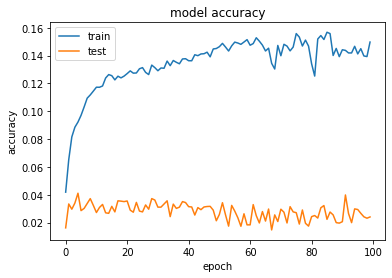

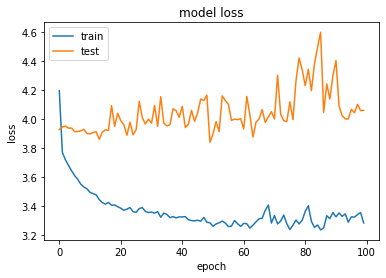

In [37]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

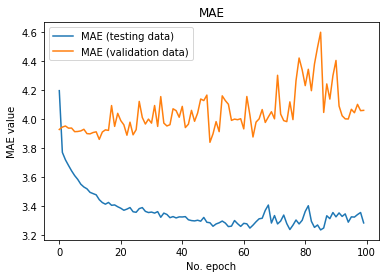

In [38]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

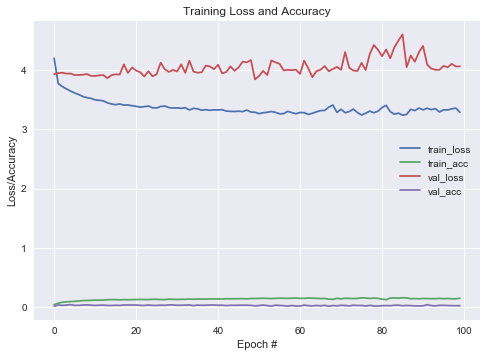

In [39]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochInceptionResNetV2_OF.png')
plt.close()